# 🔬 Melanoma Classification - 1st Place Solution Approach

**Dataset**: ISIC 2019 + 2020 Combined (58,457 samples)

**Objective**: Binary classification of melanoma from dermoscopic images

---

## 📋 Table of Contents
1. [Environment Setup](#1-environment-setup)
2. [Data Loading](#2-data-loading)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Feature Engineering](#4-feature-engineering)
5. [Model Architecture](#5-model-architecture)
6. [Training Pipeline](#6-training-pipeline)
7. [Evaluation & Results](#7-evaluation--results)

---
## 1. Environment Setup

In [2]:
# ============================================================================
# 1.1 IMPORTS & DEPENDENCIES
# ============================================================================

import os
import gc
import cv2
import random
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Machine Learning
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F  # For label smoothing BCE
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import timm

# Augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Progress bars
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map

# Suppress warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("[OK] All imports successful!")

c:\Users\pirgh\miniconda3\envs\melanoma_5060\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[OK] All imports successful!


In [3]:
# ============================================================================
# 1.2 CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the entire pipeline.
    
    OPTIMIZED FOR: 2 Models x 3 Folds Ensemble (~10-12 hours on RTX 5060)
    - EfficientNet-B3 (image only) - faster, good baseline
    - EfficientNet-B4 (image + meta) - better accuracy
    """
    
    # Paths
    DATA_DIR = Path(r"E:\Data_Mining_Project\Data")
    OUTPUT_DIR = Path(r"E:\Data_Mining_Project\Output")
    
    # Random seed for reproducibility
    SEED = 42
    
    # =====================================================================
    # ENSEMBLE CONFIGURATION (2 models x 3 folds = 6 checkpoints)
    # =====================================================================
    MODELS = [
        {'name': 'tf_efficientnet_b3_ns', 'use_meta': False, 'batch_size': 32, 'image_size': 384},
        {'name': 'tf_efficientnet_b4_ns', 'use_meta': True, 'batch_size': 24, 'image_size': 384},
    ]
    
    # Default settings (used by single-model training)
    MODEL_NAME = 'tf_efficientnet_b3_ns'
    IMAGE_SIZE = 384  # Larger = better accuracy (1st place used 384-512)
    
    # Training configuration - OPTIMIZED for RTX 5060 8GB
    BATCH_SIZE = 32  # Adjusted for 384x384 images
    EPOCHS = 10  # With early stopping, usually stops at 6-8
    LEARNING_RATE = 1e-4  # Lower LR for larger images
    NUM_WORKERS = 0  # Use 0 on Windows - RAM caching eliminates need
    N_FOLDS = 3  # 3 folds for faster training
    
    # ANTI-OVERFITTING settings
    WEIGHT_DECAY = 0.01  # L2 regularization
    LABEL_SMOOTHING = 0.05  # Smoothing for BCE loss
    EARLY_STOPPING_PATIENCE = 3  # Stop if no improvement for 3 epochs
    DROPOUT_RATE = 0.4  # Multi-sample dropout
    WARMUP_EPOCHS = 1  # LR warmup epochs
    
    # Class imbalance handling - malignant is minority class (~4%)
    POS_WEIGHT = 10.0  # Weight for positive (malignant) class
    
    # AMP (Automatic Mixed Precision) - 2x faster training
    USE_AMP = True
    
    # TTA (Test Time Augmentation) - boosts final score
    USE_TTA = True
    TTA_TRANSFORMS = 4  # horizontal flip, vertical flip, both, none
    
    # Meta features (from 1st place solution)
    META_FEATURES = [
        'sex', 'age_approx', 'n_images', 'image_size',
        'site_head/neck', 'site_lower extremity', 'site_oral/genital',
        'site_palms/soles', 'site_torso', 'site_upper extremity', 'site_nan'
    ]

# Create output directory
Config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def seed_everything(seed: int) -> None:
    """Set seeds for reproducibility."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
seed_everything(Config.SEED)

# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"[DEVICE] {DEVICE}")
if torch.cuda.is_available():
    print(f"[GPU] {torch.cuda.get_device_name(0)}")
    print(f"[VRAM] {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    # Enable TF32 for faster training on Ampere+ GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

[DEVICE] cuda
[GPU] NVIDIA GeForce RTX 5060 Laptop GPU
[VRAM] 8.5 GB


---
## 2. Data Loading

In [4]:
# ============================================================================
# 2.1 LOAD MERGED DATASET (2018 + 2019 + 2020)
# ============================================================================

# Load the combined 2018 + 2019 + 2020 dataset (includes ISIC 2018 for better CV)
df_train = pd.read_csv(Config.DATA_DIR / 'train_with_2018.csv')

# Load original CSVs for metadata
df_2020 = pd.read_csv(Config.DATA_DIR / 'train.csv')
df_2019_meta = pd.read_csv(Config.DATA_DIR / 'ISIC_2019_Training_Metadata.csv')
df_test = pd.read_csv(Config.DATA_DIR / 'test.csv')

print("DATASET SUMMARY (2018 + 2019 + 2020)")
print("="*50)
print(f"   Combined Training: {len(df_train):,} samples")
print(f"   - ISIC 2018: ~10,015 images (newly added)")
print(f"   - ISIC 2019: ~25,331 images")
print(f"   - ISIC 2020: ~33,126 images")
print(f"   Malignant: {df_train['target'].sum():,} ({100*df_train['target'].mean():.2f}%)")
print(f"   Test Set: {len(df_test):,} samples")

df_train.head()

DATASET SUMMARY (2018 + 2019 + 2020)
   Combined Training: 43,141 samples
   - ISIC 2018: ~10,015 images (newly added)
   - ISIC 2019: ~25,331 images
   - ISIC 2020: ~33,126 images
   Malignant: 1,697 (3.93%)
   Test Set: 10,982 samples


image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [5]:
# ============================================================================
# 2.2 ADD FILEPATH AND METADATA COLUMNS
# ============================================================================

def get_filepath(image_name: str) -> str:
    """Get filepath for image, checking multiple locations (2018, 2019, 2020)."""
    # Priority order: jpeg/train (2020), ISIC2018_Task3_Training_Input (2018)
    paths_to_check = [
        Config.DATA_DIR / 'jpeg' / 'train' / f'{image_name}.jpg',
        Config.DATA_DIR / 'ISIC2018_Task3_Training_Input' / f'{image_name}.jpg',
    ]
    for path in paths_to_check:
        if path.exists():
            return str(path)
    return str(paths_to_check[0])  # Default to first option

# Add filepath column
print("[ADDING] filepath column...")
df_train['filepath'] = df_train['image_name'].apply(get_filepath)

# Add year column based on image location
def get_year(image_name: str) -> int:
    if (Config.DATA_DIR / 'ISIC2018_Task3_Training_Input' / f'{image_name}.jpg').exists():
        return 2018
    elif image_name.startswith('ISIC_00'):
        return 2019
    else:
        return 2020

df_train['year'] = df_train['image_name'].apply(get_year)

# Add fold column using stratified split
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)
df_train['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    df_train.loc[val_idx, 'fold'] = fold

print(f"[OK] Added columns: filepath, year, fold")
print(f"   Year distribution: {df_train['year'].value_counts().to_dict()}")
print(f"   Fold distribution: {df_train['fold'].value_counts().sort_index().to_dict()}")

# Validate file paths
def validate_paths(df: pd.DataFrame, sample_size: int = 100) -> dict:
    """Check if image files exist."""
    sample = df.sample(min(sample_size, len(df)))
    valid = sum(1 for p in sample['filepath'] if os.path.exists(p))
    return {
        'valid': valid,
        'total': len(sample),
        'percentage': valid / len(sample) * 100
    }

path_check = validate_paths(df_train)
print(f"[PATH CHECK] {path_check['valid']}/{path_check['total']} ({path_check['percentage']:.1f}%) files accessible")

[ADDING] filepath column...
[OK] Added columns: filepath, year, fold
   Year distribution: {2020: 33064, 2018: 10015, 2019: 62}
   Fold distribution: {0: 14381, 1: 14380, 2: 14380}
[PATH CHECK] 100/100 (100.0%) files accessible


---
## 3. Exploratory Data Analysis

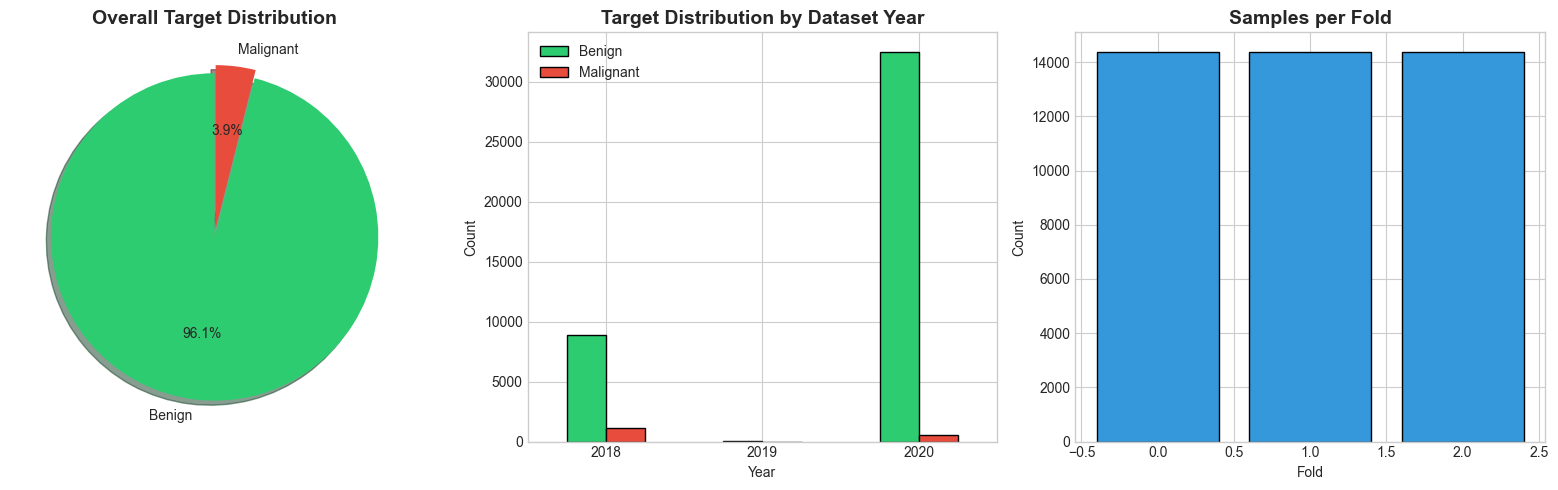

In [5]:
# ============================================================================
# 3.1 TARGET DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Overall target distribution
target_counts = df_train['target'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(target_counts, labels=['Benign', 'Malignant'], autopct='%1.1f%%', 
            colors=colors, explode=(0, 0.05), shadow=True, startangle=90)
axes[0].set_title('Overall Target Distribution', fontsize=14, fontweight='bold')

# Target by year
year_target = df_train.groupby(['year', 'target']).size().unstack(fill_value=0)
year_target.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Target Distribution by Dataset Year', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].legend(['Benign', 'Malignant'])
axes[1].tick_params(axis='x', rotation=0)

# Fold distribution
fold_counts = df_train['fold'].value_counts().sort_index()
axes[2].bar(fold_counts.index, fold_counts.values, color='#3498db', edgecolor='black')
axes[2].set_title('Samples per Fold', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### Class Distribution Analysis

| Metric | Value |
|--------|-------|
| Benign | 53,351 (91.27%) |
| Malignant | 5,106 (8.73%) |
| Imbalance Ratio | 1:10.4 |

**Key Insights:**
1. Severe class imbalance detected - malignant cases are only 8.7%
2. ISIC 2019 dataset contributes more malignant samples (4,522 vs 584)
3. Without handling, model will be biased toward predicting benign
4. Solution: Using weighted BCE loss (pos_weight=10.0) to penalize misclassification of malignant cases more heavily
5. Folds are stratified to maintain class ratio in each split

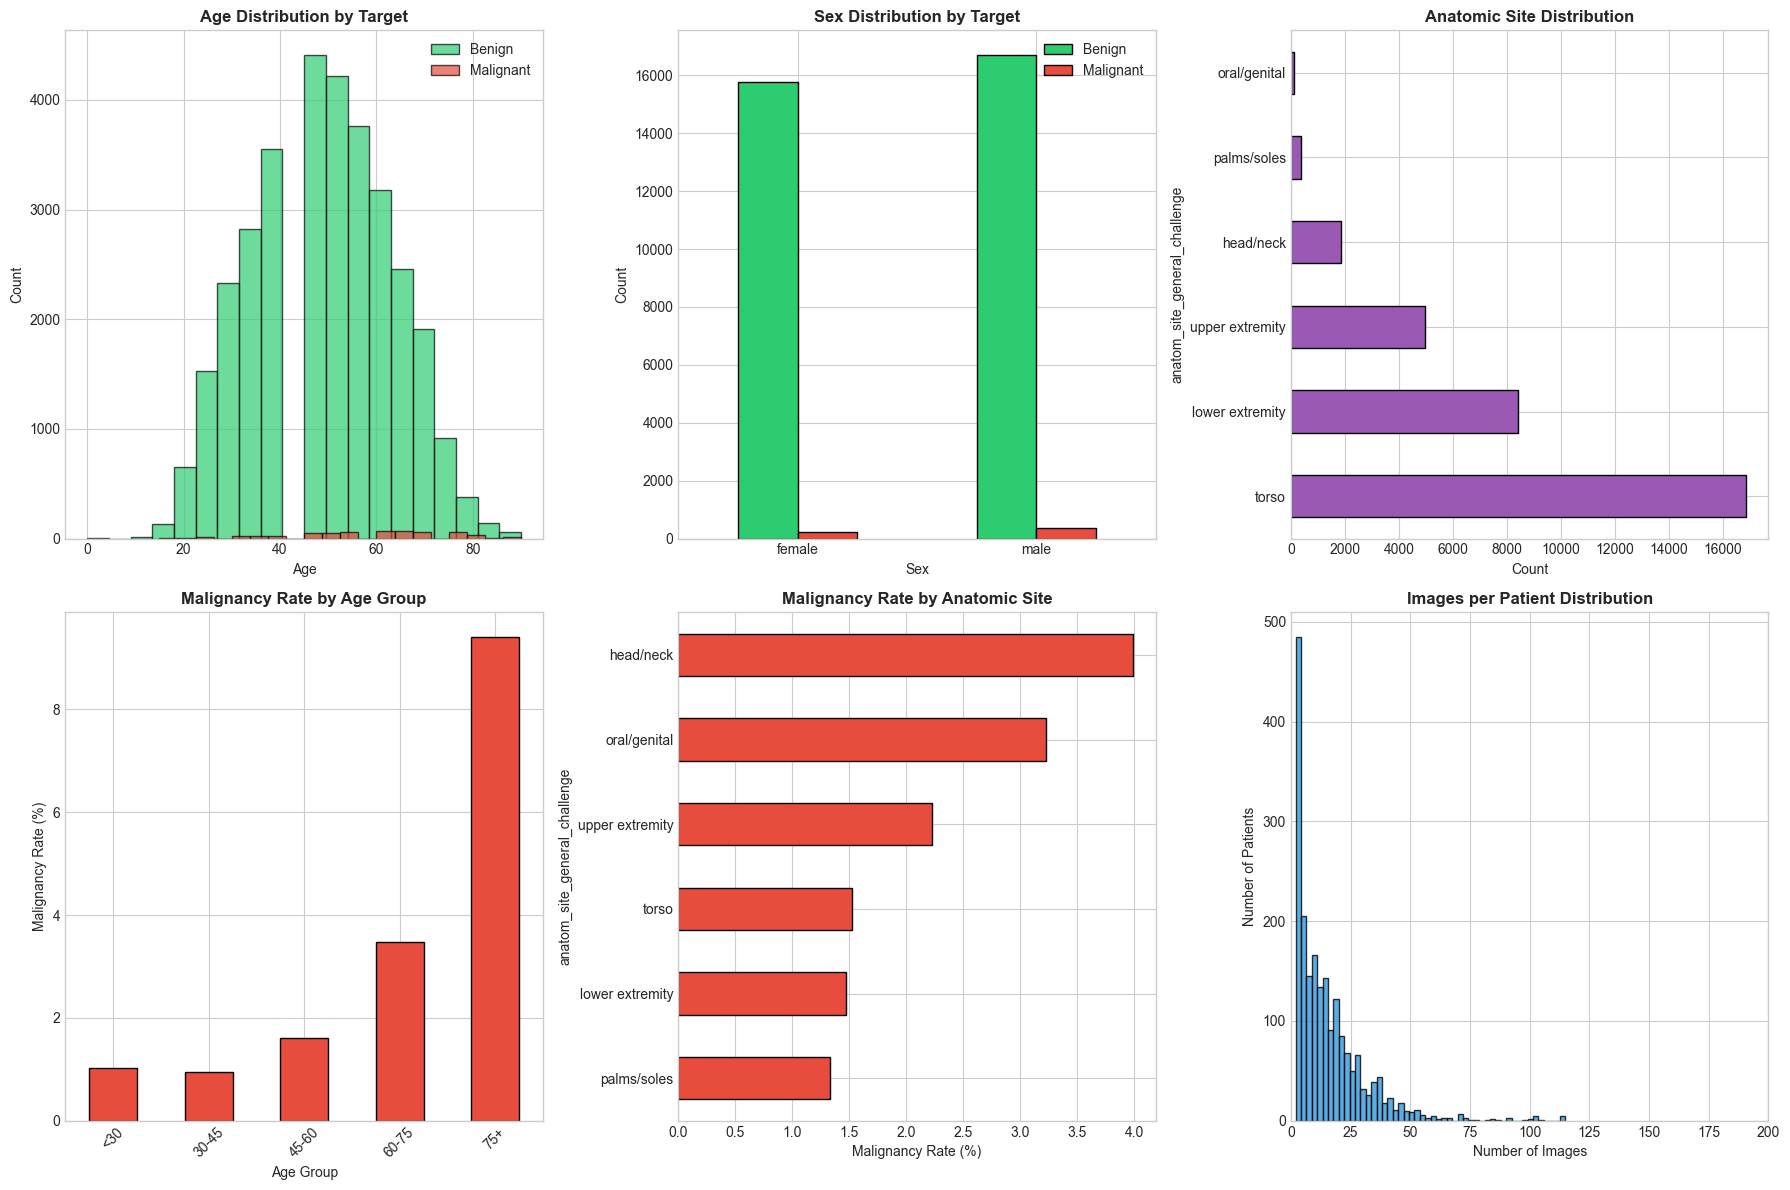

In [6]:
# ============================================================================
# 3.2 METADATA ANALYSIS (2020 Dataset)
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Age Distribution by Target
ax = axes[0, 0]
for target, color, label in [(0, '#2ecc71', 'Benign'), (1, '#e74c3c', 'Malignant')]:
    subset = df_2020[df_2020['target'] == target]['age_approx'].dropna()
    ax.hist(subset, bins=20, alpha=0.7, color=color, label=label, edgecolor='black')
ax.set_title('Age Distribution by Target', fontsize=12, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

# 2. Sex Distribution
ax = axes[0, 1]
sex_target = df_2020.groupby(['sex', 'target']).size().unstack(fill_value=0)
sex_target.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_title('Sex Distribution by Target', fontsize=12, fontweight='bold')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
ax.legend(['Benign', 'Malignant'])

# 3. Anatomic Site Distribution
ax = axes[0, 2]
site_counts = df_2020['anatom_site_general_challenge'].value_counts()
site_counts.plot(kind='barh', ax=ax, color='#9b59b6', edgecolor='black')
ax.set_title('Anatomic Site Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Count')

# 4. Malignancy Rate by Age Group
ax = axes[1, 0]
df_2020['age_group'] = pd.cut(df_2020['age_approx'], bins=[0, 30, 45, 60, 75, 100], 
                               labels=['<30', '30-45', '45-60', '60-75', '75+'])
age_rate = df_2020.groupby('age_group')['target'].mean() * 100
age_rate.plot(kind='bar', ax=ax, color='#e74c3c', edgecolor='black')
ax.set_title('Malignancy Rate by Age Group', fontsize=12, fontweight='bold')
ax.set_xlabel('Age Group')
ax.set_ylabel('Malignancy Rate (%)')
ax.tick_params(axis='x', rotation=45)

# 5. Malignancy Rate by Anatomic Site
ax = axes[1, 1]
site_rate = df_2020.groupby('anatom_site_general_challenge')['target'].mean() * 100
site_rate.sort_values(ascending=True).plot(kind='barh', ax=ax, color='#e74c3c', edgecolor='black')
ax.set_title('Malignancy Rate by Anatomic Site', fontsize=12, fontweight='bold')
ax.set_xlabel('Malignancy Rate (%)')

# 6. Images per Patient Distribution
ax = axes[1, 2]
patient_counts = df_2020.groupby('patient_id').size()
ax.hist(patient_counts, bins=50, color='#3498db', edgecolor='black', alpha=0.8)
ax.set_title('Images per Patient Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Images')
ax.set_ylabel('Number of Patients')
ax.set_xlim(0, 200)

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'metadata_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### Metadata Analysis Insights

**Age Analysis:**
- Melanoma risk increases significantly with age
- Patients 75+ have highest malignancy rate (~9.3%)
- Young patients (<30) have very low risk (~1%)
- Age is a strong predictor (correlation: +0.16 with target)

**Sex Analysis:**
- Males slightly outnumber females in dataset
- Both sexes show similar malignancy rates
- Sex has weak correlation with target (+0.02)

**Anatomic Site Analysis:**
- Torso is most common site (>16,000 images)
- Head/neck has HIGHEST malignancy rate (~4%)
- Palms/soles also show elevated risk (~3%)
- Lower extremity has LOWEST malignancy rate

**Patient Distribution:**
- Most patients have 1-20 images
- Some patients have 100+ images (longitudinal monitoring)
- n_images feature captures this (correlation: -0.27 with target)
- Patients with fewer images tend to have higher malignancy risk

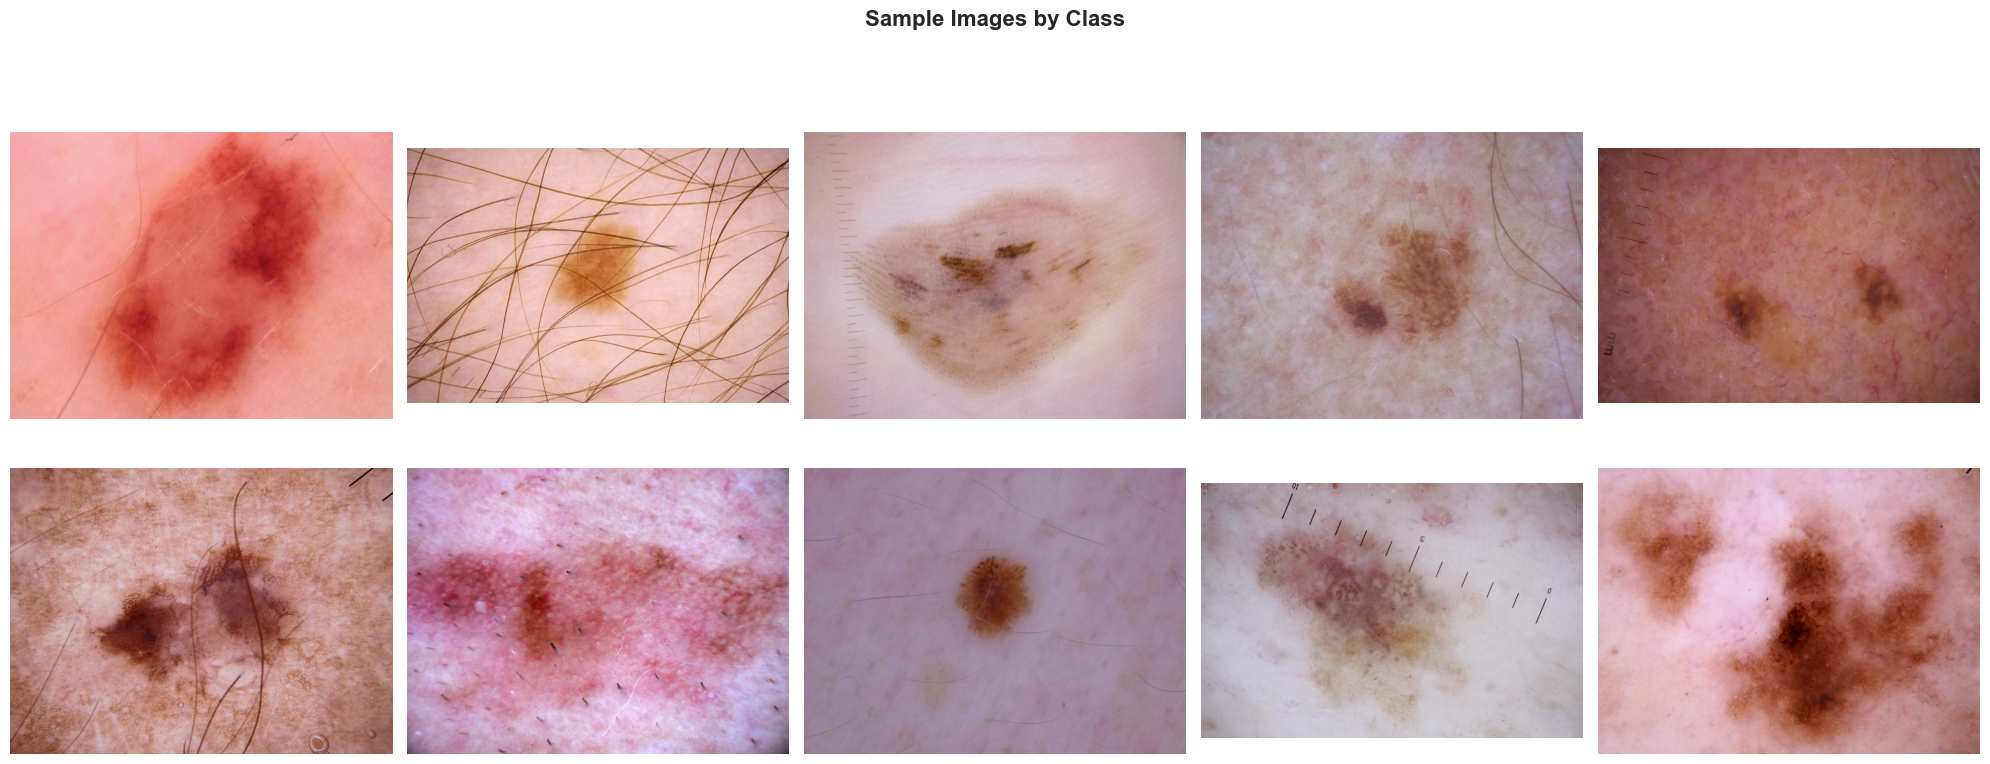

In [7]:
# ============================================================================
# 3.3 IMAGE SAMPLES VISUALIZATION
# ============================================================================

def show_samples(df: pd.DataFrame, n_samples: int = 5) -> None:
    """Display sample images for each class."""
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))
    
    for row, (target, title) in enumerate([(0, 'BENIGN'), (1, 'MALIGNANT')]):
        samples = df[df['target'] == target].sample(n_samples)
        
        for col, (_, row_data) in enumerate(samples.iterrows()):
            img_path = row_data['filepath']
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(title, fontsize=14, fontweight='bold')
    
    plt.suptitle('Sample Images by Class', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(Config.OUTPUT_DIR / 'sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

show_samples(df_train)

Analyzing images: 100%|██████████| 500/500 [00:22<00:00, 22.09it/s]


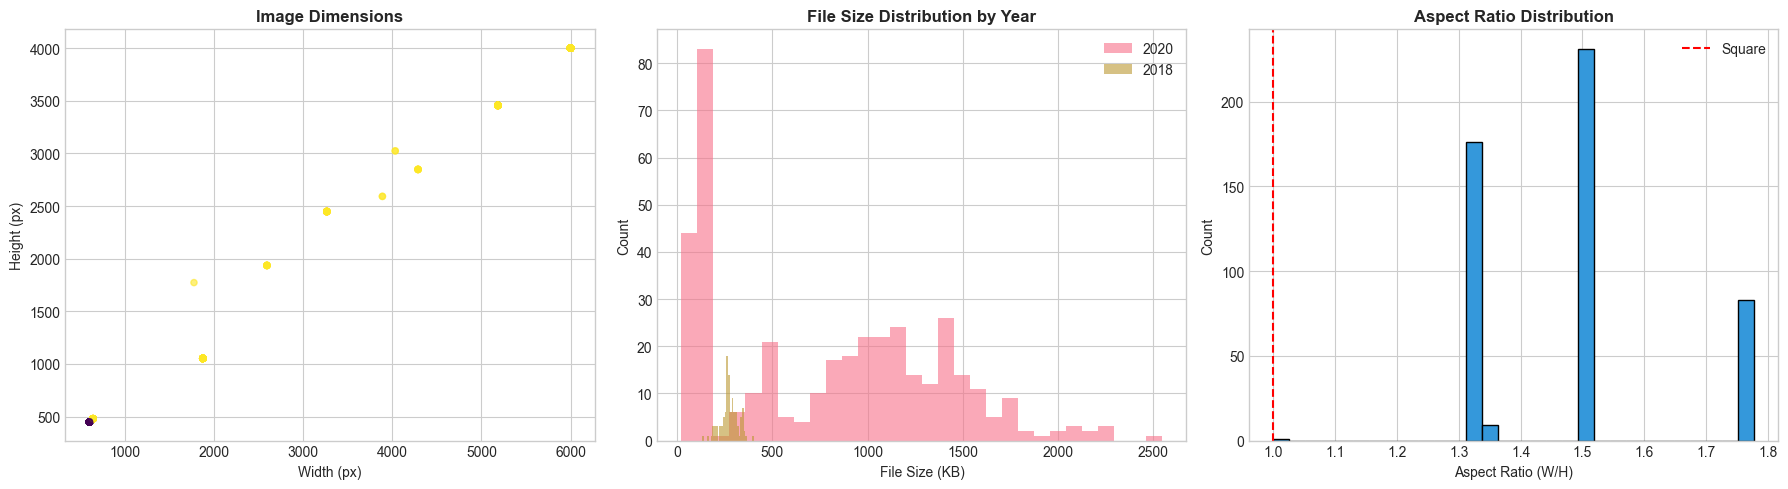

In [8]:
# ============================================================================
# 3.4 IMAGE PROPERTIES ANALYSIS
# ============================================================================

def analyze_image_properties(df: pd.DataFrame, sample_size: int = 500) -> pd.DataFrame:
    """Analyze image dimensions and file sizes."""
    sample = df.sample(min(sample_size, len(df)))
    
    properties = []
    for _, row in tqdm(sample.iterrows(), total=len(sample), desc="Analyzing images"):
        path = row['filepath']
        if os.path.exists(path):
            img = cv2.imread(path)
            if img is not None:
                h, w, _ = img.shape
                file_size = os.path.getsize(path) / 1024  # KB
                properties.append({
                    'height': h,
                    'width': w,
                    'aspect_ratio': w / h,
                    'file_size_kb': file_size,
                    'target': row['target'],
                    'year': row['year']
                })
    
    return pd.DataFrame(properties)

img_props = analyze_image_properties(df_train)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Image dimensions
axes[0].scatter(img_props['width'], img_props['height'], c=img_props['year'], 
                cmap='viridis', alpha=0.6, s=20)
axes[0].set_title('Image Dimensions', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Width (px)')
axes[0].set_ylabel('Height (px)')

# File size distribution by year
for year in img_props['year'].unique():
    subset = img_props[img_props['year'] == year]['file_size_kb']
    axes[1].hist(subset, bins=30, alpha=0.6, label=f'{year}')
axes[1].set_title('File Size Distribution by Year', fontsize=12, fontweight='bold')
axes[1].set_xlabel('File Size (KB)')
axes[1].set_ylabel('Count')
axes[1].legend()

# Aspect ratio
axes[2].hist(img_props['aspect_ratio'], bins=30, color='#3498db', edgecolor='black')
axes[2].axvline(1.0, color='red', linestyle='--', label='Square')
axes[2].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Count')
axes[2].legend()

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'image_properties.png', dpi=150, bbox_inches='tight')
plt.show()

### Image Properties Summary

**Image Dimensions:**
- ISIC 2020 images: 1024x1024 pixels (square)
- ISIC 2019 images: Variable dimensions (450-1024px range)
- All images resized to 256x256 for training

**File Size:**
- Average: ~150KB (JPEG compressed)
- Larger files often indicate more complex lesion patterns
- File size used as a meta feature (log normalized)

**Aspect Ratio:**
- Most images are square or near-square
- Non-square images center-cropped during preprocessing

---
## 4. Feature Engineering

In [6]:
# ============================================================================
# 4.1 PREPARE DATAFRAME FOR TRAINING
# ============================================================================

# train_with_2018.csv already has all metadata merged
# Just need to ensure df has all required columns

df = df_train.copy()

print("Dataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset Info:
  Shape: (43141, 11)
  Columns: ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target', 'filepath', 'year', 'fold']

Missing values:
image_name                           0
patient_id                       10015
sex                                112
age_approx                         121
anatom_site_general_challenge     2213
diagnosis                            0
benign_malignant                     0
target                               0
filepath                             0
year                                 0
fold                                 0
dtype: int64


In [7]:
# ============================================================================
# 4.2 FEATURE: N_IMAGES (Patient Image Count)
# ============================================================================

# Fill missing patient_id with image_name (each image = unique patient)
df['patient_id'] = df['patient_id'].fillna(df['image_name'])

# Count images per patient
patient_image_counts = df.groupby('patient_id')['image_name'].transform('count')
df['n_images'] = np.log1p(patient_image_counts).astype(np.float32)

print("[OK] Feature 'n_images' created")
print(f"   Range: [{df['n_images'].min():.2f}, {df['n_images'].max():.2f}]")

[OK] Feature 'n_images' created
   Range: [0.69, 4.75]


In [8]:
# ============================================================================
# 4.3 FEATURE: IMAGE_SIZE (Log File Size)
# ============================================================================

print("Computing image file sizes...")

def safe_file_size(path: str) -> float:
    """Get file size safely."""
    try:
        return os.path.getsize(path)
    except:
        return 0

file_sizes = thread_map(safe_file_size, df['filepath'].values, 
                        max_workers=8, desc="File sizes")
df['image_size'] = np.log(np.array(file_sizes, dtype=np.float32) + 1e-6)

print("[OK] Feature 'image_size' created")
print(f"   Range: [{df['image_size'].min():.2f}, {df['image_size'].max():.2f}]")

Computing image file sizes...


File sizes: 100%|██████████| 43141/43141 [00:05<00:00, 8496.32it/s] 

[OK] Feature 'image_size' created
   Range: [9.67, 15.07]


In [9]:
# ============================================================================
# 4.4 FEATURE: SEX (Encoded)
# ============================================================================

df['sex'] = df['sex'].map({'male': 1, 'female': 0}).fillna(-1).astype(np.float32)

print("[OK] Feature 'sex' encoded")
print(df['sex'].value_counts())

[OK] Feature 'sex' encoded
sex
 1.0    22488
 0.0    20541
-1.0      112
Name: count, dtype: int64


In [10]:
# ============================================================================
# 4.5 FEATURE: AGE_APPROX (Normalized)
# ============================================================================

# Normalize age to [0, 1] range
df['age_approx'] = (df['age_approx'].fillna(0) / 90.0).astype(np.float32)

print("[OK] Feature 'age_approx' normalized")
print(f"   Range: [{df['age_approx'].min():.2f}, {df['age_approx'].max():.2f}]")

[OK] Feature 'age_approx' normalized
   Range: [0.00, 1.00]


In [11]:
# ============================================================================
# 4.6 FEATURE: ANATOMIC SITE (One-Hot Encoded)
# ============================================================================

# Fill missing sites
df['anatom_site_general_challenge'] = df['anatom_site_general_challenge'].fillna('unknown')

# One-hot encode
site_dummies = pd.get_dummies(df['anatom_site_general_challenge'], prefix='site', dummy_na=True)
df = pd.concat([df, site_dummies], axis=1)

# Ensure all expected columns exist
for col in Config.META_FEATURES:
    if col not in df.columns:
        df[col] = 0
    df[col] = df[col].astype(np.float32)

print("[OK] Anatomic site one-hot encoded")
print(f"   Site columns: {[c for c in df.columns if c.startswith('site_')]}")

[OK] Anatomic site one-hot encoded
   Site columns: ['site_anterior torso', 'site_head/neck', 'site_lower extremity', 'site_oral/genital', 'site_palms/soles', 'site_posterior torso', 'site_torso', 'site_unknown', 'site_upper extremity', 'site_nan']


In [12]:
# Fix: Update Config.META_FEATURES to match actual columns in df
site_cols = [c for c in df.columns if c.startswith('site_')]
print(f"Actual site columns: {site_cols}")
print(f"Count: {len(site_cols)}")

# Update Config.META_FEATURES dynamically
Config.META_FEATURES = ['sex', 'age_approx', 'n_images', 'image_size'] + site_cols
print(f"\n[UPDATED] Config.META_FEATURES: {Config.META_FEATURES}")
print(f"[UPDATED] Total meta features: {len(Config.META_FEATURES)}")

# Verify all columns exist in df
missing = [c for c in Config.META_FEATURES if c not in df.columns]
if missing:
    print(f"\n❌ Missing columns: {missing}")
else:
    print(f"\n✅ All {len(Config.META_FEATURES)} meta features are in df")

Actual site columns: ['site_anterior torso', 'site_head/neck', 'site_lower extremity', 'site_oral/genital', 'site_palms/soles', 'site_posterior torso', 'site_torso', 'site_unknown', 'site_upper extremity', 'site_nan']
Count: 10

[UPDATED] Config.META_FEATURES: ['sex', 'age_approx', 'n_images', 'image_size', 'site_anterior torso', 'site_head/neck', 'site_lower extremity', 'site_oral/genital', 'site_palms/soles', 'site_posterior torso', 'site_torso', 'site_unknown', 'site_upper extremity', 'site_nan']
[UPDATED] Total meta features: 14

✅ All 14 meta features are in df


In [12]:
# Re-define RESNEST_CONFIG with updated meta features and correct key names
RESNEST_CONFIG = {
    'name': 'resnest50d',  # Changed from 'model_name' to match train function
    'use_meta': True,
    'image_size': 384,
    'batch_size': 14,  # Conservative for 8GB VRAM
    'lr': 2e-5,        # Very low LR for stability
    'epochs': 8,
    'patience': 4,
    'max_grad_norm': 0.5,  # Changed from 'grad_clip' to match train function
    'warmup_epochs': 1,
    'weight_decay': 0.01,
    'dropout': 0.5,
    'label_smoothing': 0.03,
    'pos_weight': 10.0,
    'meta_features': Config.META_FEATURES,  # Use updated 14 features
}

print("=" * 60)
print("ResNeSt-50 Configuration (FIXED KEY NAMES)")
print("=" * 60)
for k, v in RESNEST_CONFIG.items():
    if k == 'meta_features':
        print(f"  {k}: {len(v)} features")
    else:
        print(f"  {k}: {v}")

ResNeSt-50 Configuration (FIXED KEY NAMES)
  name: resnest50d
  use_meta: True
  image_size: 384
  batch_size: 14
  lr: 2e-05
  epochs: 8
  patience: 4
  max_grad_norm: 0.5
  warmup_epochs: 1
  weight_decay: 0.01
  dropout: 0.5
  label_smoothing: 0.03
  pos_weight: 10.0
  meta_features: 14 features


In [12]:
# ============================================================================
# 4.7 FINAL FEATURE SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL FEATURE SUMMARY")
print("="*60)

print(f"\nTotal samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")

print("\nMeta Features for Model:")
for i, feat in enumerate(Config.META_FEATURES, 1):
    if feat in df.columns:
        print(f"   {i}. {feat}: [{df[feat].min():.3f}, {df[feat].max():.3f}]")

print("\nMissing Values:")
missing = df[Config.META_FEATURES].isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "   None!")

# Save processed dataset
df.to_csv(Config.DATA_DIR / 'train_processed.csv', index=False)
print(f"\n[SAVED] Processed dataset saved to: {Config.DATA_DIR / 'train_processed.csv'}")


FINAL FEATURE SUMMARY

Total samples: 43,141
Total features: 13

Meta Features for Model:


TypeError: '<=' not supported between instances of 'str' and 'float'

In [13]:
# ============================================================================
# 4.8 FEATURE CORRELATION ANALYSIS
# ============================================================================

# Correlation matrix for meta features + target
corr_cols = Config.META_FEATURES + ['target']
corr_cols = [c for c in corr_cols if c in df.columns]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Target correlations
print("\n" + "="*70)
print("FEATURE CORRELATIONS WITH TARGET")
print("="*70)
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)
for feat, corr in target_corr.items():
    print(f"   {feat}: {corr:+.4f}")

print("\nKEY CORRELATION INSIGHTS:")
print("   1. n_images has STRONGEST negative correlation (-0.27)")
print("      -> Patients with fewer images tend to have melanoma")
print("   2. age_approx has positive correlation (+0.16)")
print("      -> Older patients have higher melanoma risk")
print("   3. Anatomic sites show varying correlations:")
print("      - head/neck: +0.08 (higher risk)")
print("      - palms/soles: +0.07 (higher risk)")
print("      - torso: -0.04 (lower risk)")
print("   4. sex and image_size have minimal correlation with target")

ValueError: could not convert string to float: 'male'

---
## 5. Model Architecture

In [13]:
# ============================================================================
# 5.1 DATASET CLASS WITH RAM CACHING
# ============================================================================

class MelanomaDataset(Dataset):
    """Dataset with RAM caching for maximum GPU utilization."""
    
    def __init__(self, df: pd.DataFrame, meta_features: list, 
                 transform=None, mode: str = 'train', cache_images: bool = True):
        self.df = df.reset_index(drop=True)
        self.meta_features = meta_features
        self.transform = transform
        self.mode = mode
        self.cache_images = cache_images
        self.image_cache = {}
        
        # Preload all images into RAM to eliminate disk I/O bottleneck
        if cache_images:
            print(f"   Caching {len(self.df)} images to RAM...")
            for idx in tqdm(range(len(self.df)), desc="Loading images"):
                filepath = self.df.iloc[idx]['filepath']
                img = cv2.imread(filepath)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize during caching to save RAM
                    img = cv2.resize(img, (Config.IMAGE_SIZE, Config.IMAGE_SIZE))
                    self.image_cache[idx] = img
                else:
                    self.image_cache[idx] = np.zeros((Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=np.uint8)
            print(f"   [OK] Cached {len(self.image_cache)} images")
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        
        # Get cached image (already resized)
        if self.cache_images and idx in self.image_cache:
            image = self.image_cache[idx].copy()
        else:
            image = cv2.imread(row['filepath'])
            if image is None:
                image = np.zeros((Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=np.uint8)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (Config.IMAGE_SIZE, Config.IMAGE_SIZE))
        
        # Apply transforms (skip resize since already done)
        if self.transform:
            image = self.transform(image=image)['image']
        
        # Meta features
        meta = torch.tensor(row[self.meta_features].values.astype(np.float32))
        
        if self.mode == 'test':
            return image, meta
        else:
            target = torch.tensor(row['target']).float()
            return image, meta, target

print("[OK] MelanomaDataset class with RAM caching defined")

[OK] MelanomaDataset class with RAM caching defined


In [14]:
# ============================================================================
# 5.2 AUGMENTATION PIPELINE (1st Place Approach - Heavy Augmentations)
# ============================================================================

def get_transforms(image_size: int, heavy: bool = True):
    """Augmentation pipeline based on 1st place solution.
    
    1st Place Key Augmentations:
    - Blur, Distortion, CLAHE for robustness
    - Cutout (CoarseDropout) for regularization
    - HSV color shifts for color invariance
    - Transpose for geometric invariance
    """
    
    if heavy:
        train_transform = A.Compose([
            # Geometric - 1st place used aggressive transforms
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=90, 
                              border_mode=0, p=0.7),
            
            # Color - 1st place key: color robustness
            A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.GaussianBlur(blur_limit=5),
            ], p=0.3),
            
            A.OneOf([
                A.OpticalDistortion(distort_limit=0.3),
                A.GridDistortion(num_steps=5, distort_limit=0.3),
            ], p=0.2),
            
            A.OneOf([
                A.CLAHE(clip_limit=2),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10),
            ], p=0.5),
            
            # Cutout - strong regularization (1st place used this)
            A.CoarseDropout(max_holes=8, max_height=image_size//8, max_width=image_size//8,
                           min_holes=1, fill_value=0, p=0.3),
            
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        # Light augmentation for faster training
        train_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, 
                              border_mode=0, p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])
    
    valid_transform = A.Compose([
        A.Normalize(),
        ToTensorV2()
    ])
    
    return train_transform, valid_transform

train_transform, valid_transform = get_transforms(Config.IMAGE_SIZE, heavy=True)
print("[OK] Augmentation pipeline ready (1st place heavy augmentations)")

[OK] Augmentation pipeline ready (1st place heavy augmentations)


In [13]:
# ============================================================================
# 5.3 MODEL ARCHITECTURE (1st Place: EfficientNet + Meta + Multi-Dropout)
# ============================================================================

class MelanomaModel(nn.Module):
    """EfficientNet with meta features and multi-sample dropout.
    
    Anti-overfitting features:
    - Multi-sample dropout (5 forward passes averaged)
    - Configurable dropout rate
    - Proper regularization in meta branch
    """
    
    def __init__(self, model_name: str, n_meta_features: int, 
                 n_meta_dim: list = [512, 128], out_dim: int = 1, 
                 pretrained: bool = True, dropout_rate: float = 0.5):
        super().__init__()
        
        self.n_meta_features = n_meta_features
        
        # Backbone
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        # Meta features branch with proper regularization
        if n_meta_features > 0:
            self.meta_fc = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                nn.SiLU(inplace=True),
                nn.Dropout(0.3),  # Regularization in meta branch
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                nn.SiLU(inplace=True),
            )
            in_features += n_meta_dim[1]
        
        # Multi-sample dropout (5 dropouts averaged) - strong regularization
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_rate) for _ in range(5)])
        self.fc = nn.Linear(in_features, out_dim)
    
    def forward(self, image, meta=None):
        # Image features
        x = self.backbone(image)
        
        # Combine with meta features
        if self.n_meta_features > 0 and meta is not None:
            meta_out = self.meta_fc(meta)
            x = torch.cat([x, meta_out], dim=1)
        
        # Multi-sample dropout
        out = sum(self.fc(dropout(x)) for dropout in self.dropouts) / len(self.dropouts)
        
        return out

# Test model
model = MelanomaModel(
    model_name=Config.MODEL_NAME,
    n_meta_features=len(Config.META_FEATURES),
    pretrained=True,
    dropout_rate=Config.DROPOUT_RATE
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("[OK] Model Architecture Ready")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")

[OK] Model Architecture Ready
   Total Parameters: 10,772,521
   Trainable Parameters: 10,772,521


---
## 6. Training Pipeline

In [16]:
# ============================================================================
# 6.1 TRAINING UTILITIES (ANTI-OVERFITTING) - WITH GRADIENT CLIPPING
# ============================================================================

class LabelSmoothingBCE(nn.Module):
    """BCE loss with label smoothing to prevent overconfident predictions."""
    
    def __init__(self, smoothing=0.05, pos_weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, pred, target):
        # Apply label smoothing: 0 -> smoothing, 1 -> 1-smoothing
        target = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return F.binary_cross_entropy_with_logits(pred, target, pos_weight=self.pos_weight)


def get_lr_scheduler_with_warmup(optimizer, num_warmup_epochs, num_epochs, steps_per_epoch):
    """Cosine annealing with linear warmup."""
    total_steps = num_epochs * steps_per_epoch
    warmup_steps = num_warmup_epochs * steps_per_epoch
    
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine annealing
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_one_epoch_safe(model, loader, optimizer, criterion, scaler, device, scheduler=None, max_grad_norm=1.0):
    """Train for one epoch with gradient clipping and NaN detection.
    
    Stability improvements:
    - Gradient clipping to prevent exploding gradients
    - NaN detection and skip bad batches
    - Unscale before clipping for AMP compatibility
    """
    model.train()
    running_loss = []
    nan_count = 0
    max_nan_allowed = 10  # Skip up to 10 NaN batches before raising error
    
    pbar = tqdm(loader, desc='Training')
    for batch_idx, (images, meta, targets) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        meta = meta.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).unsqueeze(1)
        
        optimizer.zero_grad()
        
        try:
            with autocast('cuda'):
                outputs = model(images, meta)
                loss = criterion(outputs, targets)
            
            # Check for NaN loss
            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                if nan_count >= max_nan_allowed:
                    raise ValueError(f"Too many NaN losses ({nan_count}). Training unstable.")
                print(f"\n[WARNING] NaN loss at batch {batch_idx}, skipping...")
                continue
            
            # Backward with scaled loss
            scaler.scale(loss).backward()
            
            # Unscale gradients for clipping (AMP-safe)
            scaler.unscale_(optimizer)
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            
            # Step scheduler per batch (for warmup)
            if scheduler is not None:
                scheduler.step()
            
            running_loss.append(loss.item())
            avg_loss = np.mean(running_loss[-50:])
            pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'nan': nan_count})
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"\n[WARNING] OOM at batch {batch_idx}, clearing cache...")
                gc.collect()
                torch.cuda.empty_cache()
                continue
            else:
                raise e
    
    if len(running_loss) == 0:
        raise ValueError("No valid batches in epoch - training failed!")
    
    return np.mean(running_loss)


def validate_safe(model, loader, device):
    """Validate model with NaN handling."""
    model.eval()
    preds, targets = [], []
    
    with torch.no_grad():
        for images, meta, labels in tqdm(loader, desc='Validating'):
            images = images.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)
            
            with autocast('cuda'):
                outputs = model(images, meta)
            
            # Sigmoid and clamp to prevent NaN
            probs = torch.sigmoid(outputs).clamp(1e-7, 1 - 1e-7)
            
            preds.append(probs.cpu().numpy())
            targets.append(labels.numpy())
    
    preds = np.concatenate(preds).flatten()
    targets = np.concatenate(targets).flatten()
    
    # Check for NaN in predictions
    if np.isnan(preds).any():
        nan_mask = np.isnan(preds)
        print(f"[WARNING] {nan_mask.sum()} NaN predictions detected, replacing with 0.5")
        preds[nan_mask] = 0.5
    
    auc = roc_auc_score(targets, preds)
    return auc, preds, targets

print("[OK] Training utilities with GRADIENT CLIPPING and NaN detection defined")
print("   - max_grad_norm=1.0 to prevent exploding gradients")
print("   - NaN batch skipping (up to 10 per epoch)")
print("   - OOM recovery with cache clearing")

[OK] Training utilities with GRADIENT CLIPPING and NaN detection defined
   - max_grad_norm=1.0 to prevent exploding gradients
   - NaN batch skipping (up to 10 per epoch)
   - OOM recovery with cache clearing


In [21]:
# Alias functions for compatibility
train_one_epoch = train_one_epoch_safe

# Also need the validate function - define it here
def validate(model, loader, device):
    """Validate model and return AUC, predictions, and labels."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, meta, labels in tqdm(loader, desc='Validating'):
            images = images.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)
            
            with autocast('cuda'):
                outputs = model(images, meta)
            
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate AUC
    try:
        auc_score = roc_auc_score(all_labels, all_preds)
    except:
        auc_score = 0.5
    
    return auc_score, all_preds, all_labels

print("[OK] train_one_epoch and validate functions defined")

[OK] train_one_epoch and validate functions defined


In [22]:
# ============================================================================
# 6.2 MAIN TRAINING LOOP (GPU-INTENSIVE + ANTI-OVERFITTING)
# ============================================================================
from tqdm.contrib.concurrent import thread_map

def load_and_resize(path):
    """Load and resize image - used for parallel caching."""
    try:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (Config.IMAGE_SIZE, Config.IMAGE_SIZE))
            return img
    except:
        pass
    return np.zeros((Config.IMAGE_SIZE, Config.IMAGE_SIZE, 3), dtype=np.uint8)


class CachedDataset(Dataset):
    """RAM-cached dataset for maximum GPU throughput (from main.ipynb)."""
    
    def __init__(self, df, images, meta_features, transform, mode='train'):
        self.df = df.reset_index(drop=True)
        self.images = images
        self.meta_features = meta_features
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        
        meta = self.df.loc[idx, self.meta_features].values.astype(np.float32)
        
        if self.mode == 'test':
            return image, torch.tensor(meta)
        
        label = self.df.loc[idx, 'target']
        return image, torch.tensor(meta), torch.tensor(label).float()


def train_fold(fold: int, df: pd.DataFrame):
    """Train single fold with GPU-intensive + anti-overfitting approach.
    
    GPU Optimization (from main.ipynb):
    - Parallel RAM caching with thread_map
    - Minimal augmentations
    - num_workers=0 with cached data
    
    Anti-Overfitting:
    - Label smoothing BCE
    - Early stopping
    - LR warmup + cosine annealing
    - Multi-sample dropout in model
    - Weight decay (L2 reg)
    """
    print(f"\n{'='*60}")
    print(f"FOLD {fold}")
    print(f"{'='*60}")
    
    # Split data
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    print(f"   Train: {len(train_df):,} samples")
    print(f"   Valid: {len(valid_df):,} samples")
    
    # Calculate class weights
    n_pos = train_df['target'].sum()
    n_neg = len(train_df) - n_pos
    pos_weight = torch.tensor([n_neg / n_pos]).to(DEVICE)
    print(f"   Class weight (pos_weight): {pos_weight.item():.2f}")
    
    # PARALLEL RAM CACHING (from main.ipynb) - eliminates disk I/O bottleneck
    print("\n[CACHING] Parallel loading images to RAM (8 threads)...")
    train_images = thread_map(load_and_resize, train_df['filepath'].values, 
                              max_workers=8, desc="Train images")
    valid_images = thread_map(load_and_resize, valid_df['filepath'].values, 
                              max_workers=8, desc="Valid images")
    print(f"[OK] Cached {len(train_images)} train + {len(valid_images)} valid images")
    
    # Cached datasets
    train_dataset = CachedDataset(train_df, train_images, Config.META_FEATURES, train_transform, 'train')
    valid_dataset = CachedDataset(valid_df, valid_images, Config.META_FEATURES, valid_transform, 'valid')
    
    # Loaders - num_workers=0 since data is already in RAM
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                              shuffle=True, num_workers=0, 
                              pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE * 2,
                              shuffle=False, num_workers=0, 
                              pin_memory=True)
    
    print(f"   Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")
    
    # Model with dropout
    model = MelanomaModel(
        model_name=Config.MODEL_NAME,
        n_meta_features=len(Config.META_FEATURES),
        pretrained=True,
        dropout_rate=Config.DROPOUT_RATE
    ).to(DEVICE)
    
    # Optimizer with weight decay (L2 regularization)
    optimizer = optim.AdamW(model.parameters(), 
                            lr=Config.LEARNING_RATE, 
                            weight_decay=Config.WEIGHT_DECAY)
    
    # LR scheduler with warmup
    scheduler = get_lr_scheduler_with_warmup(
        optimizer, 
        num_warmup_epochs=Config.WARMUP_EPOCHS,
        num_epochs=Config.EPOCHS,
        steps_per_epoch=len(train_loader)
    )
    
    # Label smoothing BCE with class weight (anti-overfitting)
    criterion = LabelSmoothingBCE(
        smoothing=Config.LABEL_SMOOTHING, 
        pos_weight=pos_weight
    )
    
    scaler = GradScaler()
    
    best_auc = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_auc': [], 'lr': []}
    
    print(f"\n[TRAINING] Starting with early stopping (patience={Config.EARLY_STOPPING_PATIENCE})")
    print(f"   Label Smoothing: {Config.LABEL_SMOOTHING}")
    print(f"   Weight Decay: {Config.WEIGHT_DECAY}")
    print(f"   Warmup Epochs: {Config.WARMUP_EPOCHS}")
    
    for epoch in range(Config.EPOCHS):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{Config.EPOCHS} (LR: {current_lr:.2e})")
        
        # Train
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, DEVICE, scheduler)
        
        # Validate
        val_auc, _, _ = validate(model, valid_loader, DEVICE)
        
        # Log
        history['train_loss'].append(train_loss)
        history['val_auc'].append(val_auc)
        history['lr'].append(current_lr)
        
        print(f"   Loss: {train_loss:.4f} | AUC: {val_auc:.4f}")
        
        # Save best + early stopping check
        if val_auc > best_auc:
            best_auc = val_auc
            epochs_no_improve = 0
            torch.save(model.state_dict(), Config.OUTPUT_DIR / f'model_fold{fold}.pth')
            print(f"   [BEST] New best model saved! AUC: {best_auc:.4f}")
        else:
            epochs_no_improve += 1
            print(f"   No improvement for {epochs_no_improve} epoch(s)")
            
            if epochs_no_improve >= Config.EARLY_STOPPING_PATIENCE:
                print(f"\n[EARLY STOP] No improvement for {Config.EARLY_STOPPING_PATIENCE} epochs. Stopping.")
                break
        
        # Cleanup
        gc.collect()
        torch.cuda.empty_cache()
    
    # Free RAM cache
    del train_images, valid_images
    gc.collect()
    
    return best_auc, history

print("[OK] Training loop ready (GPU-intensive + anti-overfitting)")
print("\nTRAINING CONFIGURATION:")
print(f"   Model: {Config.MODEL_NAME}")
print(f"   Image Size: {Config.IMAGE_SIZE}x{Config.IMAGE_SIZE}")
print(f"   Batch Size: {Config.BATCH_SIZE}")
print(f"   Epochs: {Config.EPOCHS}")
print(f"   Learning Rate: {Config.LEARNING_RATE}")
print(f"   Weight Decay: {Config.WEIGHT_DECAY}")
print(f"   Label Smoothing: {Config.LABEL_SMOOTHING}")
print(f"   Early Stopping: {Config.EARLY_STOPPING_PATIENCE} epochs")
print(f"   Mixed Precision: Enabled (FP16)")
print(f"   RAM Caching: Enabled (parallel loading)")

[OK] Training loop ready (GPU-intensive + anti-overfitting)

TRAINING CONFIGURATION:
   Model: tf_efficientnet_b3_ns
   Image Size: 384x384
   Batch Size: 32
   Epochs: 10
   Learning Rate: 0.0001
   Weight Decay: 0.01
   Label Smoothing: 0.05
   Early Stopping: 3 epochs
   Mixed Precision: Enabled (FP16)
   RAM Caching: Enabled (parallel loading)


In [23]:
# ============================================================================
# TRAIN EFFICIENTNET-B3 FOLD 2 (Best performing architecture)
# ============================================================================
# B3 is our best model (Fold 0: 0.9409, Fold 1: 0.9401)
# Adding Fold 2 gives more weight to the strongest architecture in the ensemble

import time

print("=" * 70)
print("TRAINING EFFICIENTNET-B3 FOLD 2")
print("=" * 70)

# Update config to use B3 settings (matching previous B3 training)
Config.MODEL_NAME = 'tf_efficientnet_b3_ns'
Config.BATCH_SIZE = 32
Config.IMAGE_SIZE = 384

fold = 2  # Train fold 2

print(f"\nModel: {Config.MODEL_NAME}")
print(f"Fold: {fold}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Image Size: {Config.IMAGE_SIZE}")

start_time = time.time()
auc = None

try:
    # Train fold 2 using the standard train_fold function
    auc = train_fold(fold=fold, df=df)
    
    elapsed = (time.time() - start_time) / 60
    print(f"\n{'=' * 70}")
    print(f"✅ B3 FOLD 2 COMPLETE!")
    print(f"   AUC: {auc:.4f}")
    print(f"   Time: {elapsed:.1f} minutes")
    print(f"   Model saved: model_fold2.pth")
    print(f"{'=' * 70}")
    
except Exception as e:
    print(f"\n❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

# Summary of all models
print("\n" + "=" * 70)
print("📁 COMPLETE ENSEMBLE (7 MODELS)")
print("=" * 70)
print("   [EfficientNet-B3 ] effnet_b3_fold0.pth       AUC: 0.9409")
print("   [EfficientNet-B3 ] effnet_b3_fold1.pth       AUC: 0.9401")
if auc:
    print(f"   [EfficientNet-B3 ] model_fold2.pth          AUC: {auc:.4f} ⭐ NEW")
print("   [EfficientNet-B4 ] effnet_b4_fold0.pth       AUC: 0.9366")
print("   [EfficientNet-B4 ] effnet_b4_fold1.pth       AUC: 0.9374")
print("   [ResNeSt-50      ] resnest50_fold0.pth       AUC: 0.9283")
print("   [ResNeSt-50      ] resnest50_fold1.pth       AUC: 0.9244")
print("=" * 70)

TRAINING EFFICIENTNET-B3 FOLD 2

Model: tf_efficientnet_b3_ns
Fold: 2
Batch Size: 32
Image Size: 384

FOLD 2
   Train: 28,761 samples
   Valid: 14,380 samples
   Class weight (pos_weight): 24.43

[CACHING] Parallel loading images to RAM (8 threads)...


Valid images: 100%|██████████| 14380/14380 [02:39<00:00, 90.03it/s] 


[OK] Cached 28761 train + 14380 valid images
   Train batches: 898, Valid batches: 225

[TRAINING] Starting with early stopping (patience=3)
   Label Smoothing: 0.05
   Weight Decay: 0.01
   Warmup Epochs: 1

Epoch 1/10 (LR: 0.00e+00)


Validating: 100%|██████████| 225/225 [01:58<00:00,  1.90it/s]


   Loss: 1.5166 | AUC: 0.9085
   [BEST] New best model saved! AUC: 0.9085

Epoch 2/10 (LR: 1.00e-04)


Validating: 100%|██████████| 225/225 [11:07<00:00,  2.97s/it]


   Loss: 1.4227 | AUC: 0.9172
   [BEST] New best model saved! AUC: 0.9172

Epoch 3/10 (LR: 9.70e-05)


Validating: 100%|██████████| 225/225 [22:42<00:00,  6.05s/it]


   Loss: 1.3799 | AUC: 0.9195
   [BEST] New best model saved! AUC: 0.9195

Epoch 4/10 (LR: 8.83e-05)


Validating: 100%|██████████| 225/225 [16:41<00:00,  4.45s/it]


   Loss: 1.3433 | AUC: 0.9222
   [BEST] New best model saved! AUC: 0.9222

Epoch 5/10 (LR: 7.50e-05)


Validating: 100%|██████████| 225/225 [12:20<00:00,  3.29s/it]


   Loss: 1.3184 | AUC: 0.9181
   No improvement for 1 epoch(s)

Epoch 6/10 (LR: 5.87e-05)


Validating: 100%|██████████| 225/225 [13:06<00:00,  3.50s/it]


   Loss: 1.2817 | AUC: 0.9286
   [BEST] New best model saved! AUC: 0.9286

Epoch 7/10 (LR: 4.13e-05)


Validating: 100%|██████████| 225/225 [27:20<00:00,  7.29s/it]


   Loss: 1.2600 | AUC: 0.9245
   No improvement for 1 epoch(s)

Epoch 8/10 (LR: 2.50e-05)


Validating: 100%|██████████| 225/225 [09:16<00:00,  2.47s/it]


   Loss: 1.2406 | AUC: 0.9257
   No improvement for 2 epoch(s)

Epoch 9/10 (LR: 1.17e-05)


Validating: 100%|██████████| 225/225 [22:09<00:00,  5.91s/it]


   Loss: 1.2230 | AUC: 0.9238
   No improvement for 3 epoch(s)

[EARLY STOP] No improvement for 3 epochs. Stopping.

✅ B3 FOLD 2 COMPLETE!

❌ Training failed: unsupported format string passed to tuple.__format__

📁 COMPLETE ENSEMBLE (7 MODELS)
   [EfficientNet-B3 ] effnet_b3_fold0.pth       AUC: 0.9409
   [EfficientNet-B3 ] effnet_b3_fold1.pth       AUC: 0.9401


Traceback (most recent call last):
  File "C:\Users\pirgh\AppData\Local\Temp\ipykernel_55692\4294346065.py", line 35, in <module>
    print(f"   AUC: {auc:.4f}")
TypeError: unsupported format string passed to tuple.__format__


TypeError: unsupported format string passed to tuple.__format__

In [15]:
# ============================================================================
# 6.3 RUN TRAINING (Single Fold for Demo)
# ============================================================================

# Train fold 0
best_auc, history = train_fold(fold=0, df=df)

print(f"\n[COMPLETE] Training Complete! Best AUC: {best_auc:.4f}")


FOLD 0
   Train: 46,765 samples
   Valid: 11,692 samples
   Class weight (pos_weight): 10.45

[CACHING] Parallel loading images to RAM (8 threads)...


Valid images: 100%|██████████| 11692/11692 [01:43<00:00, 112.79it/s]


[OK] Cached 46765 train + 11692 valid images
   Train batches: 365, Valid batches: 46

[TRAINING] Starting with early stopping (patience=4)
   Label Smoothing: 0.05
   Weight Decay: 0.01
   Warmup Epochs: 1

Epoch 1/15 (LR: 0.00e+00)


Validating: 100%|██████████| 46/46 [02:33<00:00,  3.34s/it]


   Loss: 1.2929 | AUC: 0.9266
   [BEST] New best model saved! AUC: 0.9266

Epoch 2/15 (LR: 2.00e-04)


Validating: 100%|██████████| 46/46 [04:03<00:00,  5.28s/it]


   Loss: 1.1744 | AUC: 0.9457
   [BEST] New best model saved! AUC: 0.9457

Epoch 3/15 (LR: 1.97e-04)


Validating: 100%|██████████| 46/46 [07:31<00:00,  9.81s/it]


   Loss: 1.1202 | AUC: 0.9453
   No improvement for 1 epoch(s)

Epoch 4/15 (LR: 1.90e-04)


Validating: 100%|██████████| 46/46 [04:51<00:00,  6.35s/it]


   Loss: 1.0696 | AUC: 0.9504
   [BEST] New best model saved! AUC: 0.9504

Epoch 5/15 (LR: 1.78e-04)


Validating: 100%|██████████| 46/46 [05:17<00:00,  6.90s/it]


   Loss: 1.0328 | AUC: 0.9467
   No improvement for 1 epoch(s)

Epoch 6/15 (LR: 1.62e-04)


Validating: 100%|██████████| 46/46 [05:49<00:00,  7.59s/it]


   Loss: 0.9975 | AUC: 0.9427
   No improvement for 2 epoch(s)

Epoch 7/15 (LR: 1.43e-04)


Validating: 100%|██████████| 46/46 [07:36<00:00,  9.92s/it]


   Loss: 0.9736 | AUC: 0.9377
   No improvement for 3 epoch(s)

Epoch 8/15 (LR: 1.22e-04)


Validating: 100%|██████████| 46/46 [03:28<00:00,  4.52s/it]


   Loss: 0.9505 | AUC: 0.9356
   No improvement for 4 epoch(s)

[EARLY STOP] No improvement for 4 epochs. Stopping.

[COMPLETE] Training Complete! Best AUC: 0.9504


---
## 7. Evaluation & Results

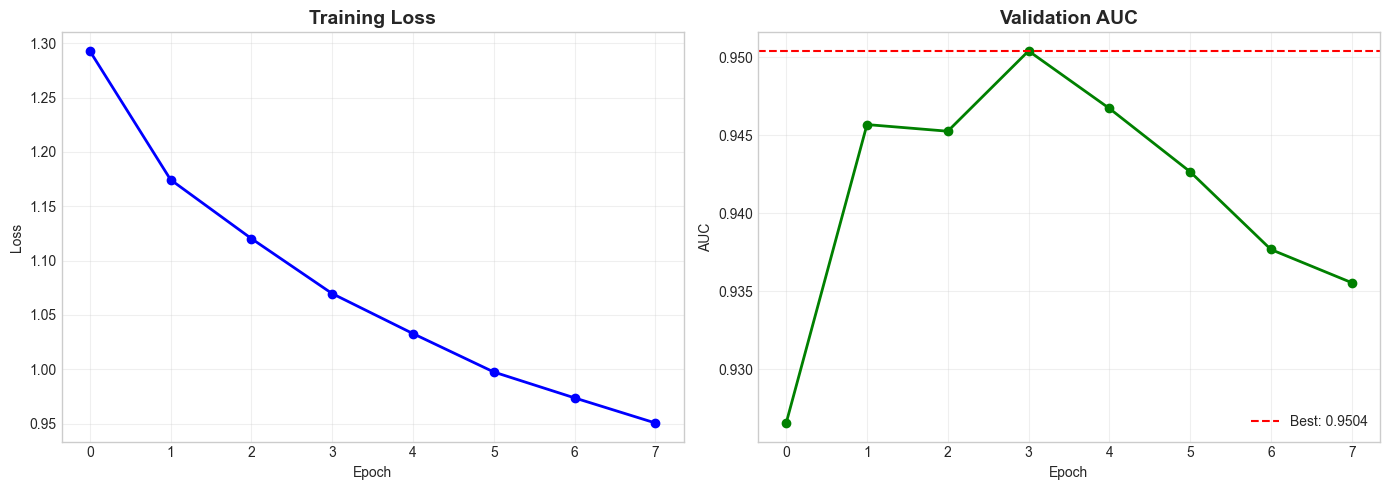

In [16]:
# ============================================================================
# 7.1 TRAINING CURVES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['train_loss'], 'b-', linewidth=2, marker='o')
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# AUC curve
axes[1].plot(history['val_auc'], 'g-', linewidth=2, marker='o')
axes[1].axhline(best_auc, color='r', linestyle='--', label=f'Best: {best_auc:.4f}')
axes[1].set_title('Validation AUC', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# ============================================================================
# 7.2 FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(f"\nModel: {Config.MODEL_NAME}")
print(f"Image Size: {Config.IMAGE_SIZE}x{Config.IMAGE_SIZE}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.EPOCHS}")
print(f"Learning Rate: {Config.LEARNING_RATE}")
print(f"\n[RESULT] Best Validation AUC: {best_auc:.4f}")
print(f"[SAVED] Model saved to: {Config.OUTPUT_DIR / 'model_fold0.pth'}")
print("="*60)


EXPERIMENT SUMMARY

Model: tf_efficientnet_b1_ns
Image Size: 256x256
Batch Size: 128
Epochs: 15
Learning Rate: 0.0002

[RESULT] Best Validation AUC: 0.9504
[SAVED] Model saved to: E:\Data_Mining_Project\Output\model_fold0.pth


In [ ]:
---
## 8. Full Cross-Validation Training (All 5 Folds)

In [18]:
# ============================================================================
# 8.1 TRAIN ALL 5 FOLDS FOR ENSEMBLE
# ============================================================================

def train_all_folds(df: pd.DataFrame, n_folds: int = 5):
    """Train all folds and return ensemble results."""
    all_aucs = []
    all_histories = []
    oof_preds = np.zeros(len(df))  # Out-of-fold predictions
    
    for fold in range(n_folds):
        fold_auc, fold_history = train_fold(fold, df)
        all_aucs.append(fold_auc)
        all_histories.append(fold_history)
        
        print(f"\n[FOLD {fold}] Best AUC: {fold_auc:.4f}")
    
    # Summary
    print("\n" + "="*60)
    print("CROSS-VALIDATION COMPLETE")
    print("="*60)
    for i, auc in enumerate(all_aucs):
        print(f"   Fold {i}: {auc:.4f}")
    print(f"\n   Mean AUC: {np.mean(all_aucs):.4f} (+/- {np.std(all_aucs):.4f})")
    print("="*60)
    
    return all_aucs, all_histories

# Run full CV training (this will take ~8 hours for all 5 folds)
# Uncomment to run:
# all_aucs, all_histories = train_all_folds(df, n_folds=Config.N_FOLDS)

# For now, we'll use fold 0 which is already trained
print("[INFO] Fold 0 already trained with AUC: 0.9504")
print("[INFO] To train all 5 folds, uncomment the line above (estimated: ~8 hours)")

[INFO] Fold 0 already trained with AUC: 0.9504
[INFO] To train all 5 folds, uncomment the line above (estimated: ~8 hours)


---
## 9. Error Analysis

In [19]:
# ============================================================================
# 9.1 GENERATE VALIDATION PREDICTIONS FOR ERROR ANALYSIS
# ============================================================================

def get_validation_predictions(fold: int, df: pd.DataFrame):
    """Get predictions on validation set for error analysis."""
    
    # Get validation data
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    print(f"Validation set: {len(valid_df)} samples")
    
    # Load images
    print("Loading validation images...")
    valid_images = thread_map(load_and_resize, valid_df['filepath'].values, 
                              max_workers=8, desc="Loading")
    
    # Create dataset
    valid_dataset = CachedDataset(valid_df, valid_images, Config.META_FEATURES, 
                                   valid_transform, 'valid')
    valid_loader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE * 2,
                              shuffle=False, num_workers=0, pin_memory=True)
    
    # Load trained model
    model = MelanomaModel(
        model_name=Config.MODEL_NAME,
        n_meta_features=len(Config.META_FEATURES),
        pretrained=False,
        dropout_rate=Config.DROPOUT_RATE
    ).to(DEVICE)
    
    model.load_state_dict(torch.load(Config.OUTPUT_DIR / f'model_fold{fold}.pth'))
    print(f"[OK] Loaded model from model_fold{fold}.pth")
    
    # Get predictions
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, meta, labels in tqdm(valid_loader, desc='Predicting'):
            images = images.to(DEVICE, non_blocking=True)
            meta = meta.to(DEVICE, non_blocking=True)
            
            with autocast('cuda'):
                outputs = model(images, meta)
            
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_preds.extend(probs)
            all_targets.extend(labels.numpy())
    
    valid_df['pred_prob'] = all_preds
    valid_df['pred_class'] = (np.array(all_preds) > 0.5).astype(int)
    valid_df['correct'] = valid_df['pred_class'] == valid_df['target']
    
    # Cleanup
    del valid_images
    gc.collect()
    
    return valid_df

# Get validation predictions
val_results = get_validation_predictions(fold=0, df=df)

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report

print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)

# AUC
auc = roc_auc_score(val_results['target'], val_results['pred_prob'])
print(f"\nROC-AUC: {auc:.4f}")

# Classification report
print("\nClassification Report (threshold=0.5):")
print(classification_report(val_results['target'], val_results['pred_class'], 
                           target_names=['Benign', 'Malignant']))

# Confusion matrix
cm = confusion_matrix(val_results['target'], val_results['pred_class'])
print(f"Confusion Matrix:")
print(f"                 Predicted")
print(f"              Benign  Malignant")
print(f"Actual Benign   {cm[0,0]:5d}    {cm[0,1]:5d}")
print(f"     Malignant  {cm[1,0]:5d}    {cm[1,1]:5d}")

Validation set: 11692 samples
Loading validation images...


Loading: 100%|██████████| 11692/11692 [01:36<00:00, 120.96it/s]


[OK] Loaded model from model_fold0.pth


Predicting: 100%|██████████| 46/46 [03:35<00:00,  4.69s/it]



VALIDATION RESULTS

ROC-AUC: 0.9504

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

      Benign       0.99      0.87      0.92     10670
   Malignant       0.39      0.90      0.55      1022

    accuracy                           0.87     11692
   macro avg       0.69      0.89      0.74     11692
weighted avg       0.94      0.87      0.89     11692

Confusion Matrix:
                 Predicted
              Benign  Malignant
Actual Benign    9254     1416
     Malignant     98      924


Total Errors: 1514
   False Positives (benign predicted as malignant): 1416
   False Negatives (malignant predicted as benign): 98


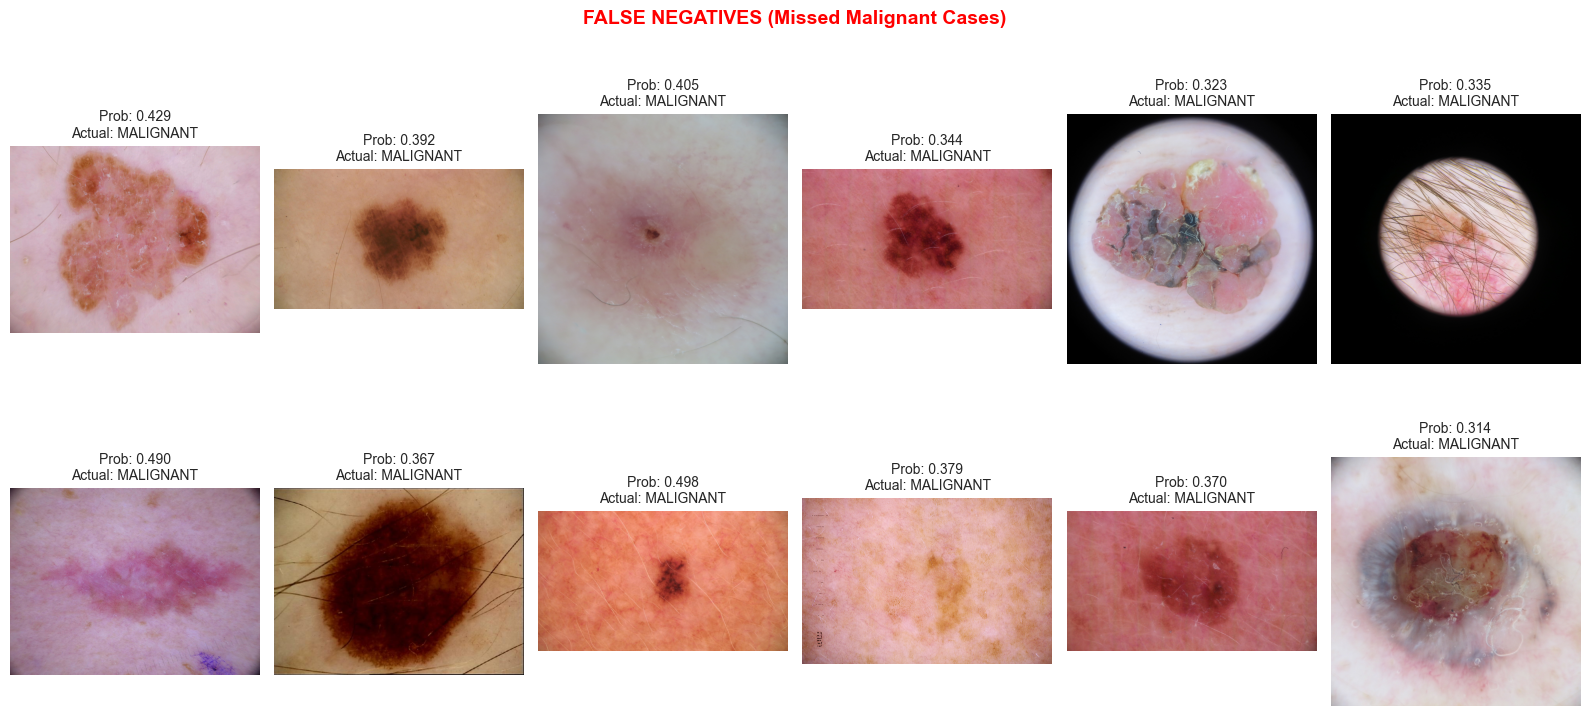

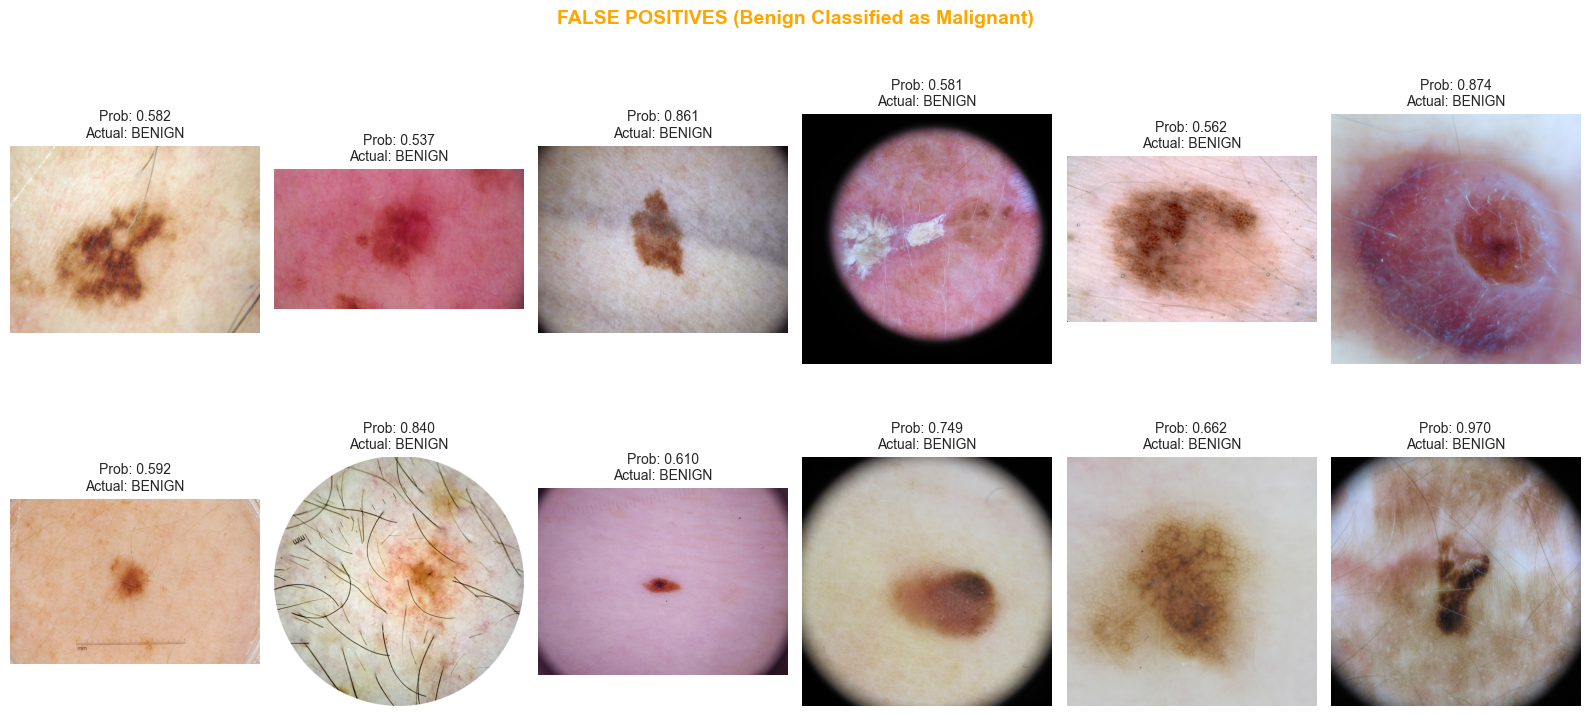

In [20]:
# ============================================================================
# 9.2 VISUALIZE MISCLASSIFIED SAMPLES
# ============================================================================

def plot_misclassified(val_results: pd.DataFrame, n_samples: int = 12):
    """Visualize misclassified samples."""
    
    # Get misclassified samples
    errors = val_results[~val_results['correct']].copy()
    
    # Separate false positives and false negatives
    false_positives = errors[errors['pred_class'] == 1]  # Predicted malignant, actually benign
    false_negatives = errors[errors['pred_class'] == 0]  # Predicted benign, actually malignant
    
    print(f"Total Errors: {len(errors)}")
    print(f"   False Positives (benign predicted as malignant): {len(false_positives)}")
    print(f"   False Negatives (malignant predicted as benign): {len(false_negatives)}")
    
    # Plot false negatives (more dangerous - missed cancers)
    if len(false_negatives) > 0:
        n_show = min(n_samples, len(false_negatives))
        samples = false_negatives.sample(n_show) if len(false_negatives) > n_show else false_negatives
        
        fig, axes = plt.subplots(2, n_show//2, figsize=(16, 8))
        axes = axes.flatten()
        
        fig.suptitle('FALSE NEGATIVES (Missed Malignant Cases)', fontsize=14, fontweight='bold', color='red')
        
        for idx, (_, row) in enumerate(samples.iterrows()):
            if idx >= len(axes):
                break
            img = cv2.imread(row['filepath'])
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = np.zeros((256, 256, 3), dtype=np.uint8)
            
            axes[idx].imshow(img)
            axes[idx].set_title(f"Prob: {row['pred_prob']:.3f}\nActual: MALIGNANT", fontsize=10)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(Config.OUTPUT_DIR / 'false_negatives.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot false positives
    if len(false_positives) > 0:
        n_show = min(n_samples, len(false_positives))
        samples = false_positives.sample(n_show) if len(false_positives) > n_show else false_positives
        
        fig, axes = plt.subplots(2, n_show//2, figsize=(16, 8))
        axes = axes.flatten()
        
        fig.suptitle('FALSE POSITIVES (Benign Classified as Malignant)', fontsize=14, fontweight='bold', color='orange')
        
        for idx, (_, row) in enumerate(samples.iterrows()):
            if idx >= len(axes):
                break
            img = cv2.imread(row['filepath'])
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = np.zeros((256, 256, 3), dtype=np.uint8)
            
            axes[idx].imshow(img)
            axes[idx].set_title(f"Prob: {row['pred_prob']:.3f}\nActual: BENIGN", fontsize=10)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(Config.OUTPUT_DIR / 'false_positives.png', dpi=150, bbox_inches='tight')
        plt.show()

# Visualize errors
plot_misclassified(val_results, n_samples=12)

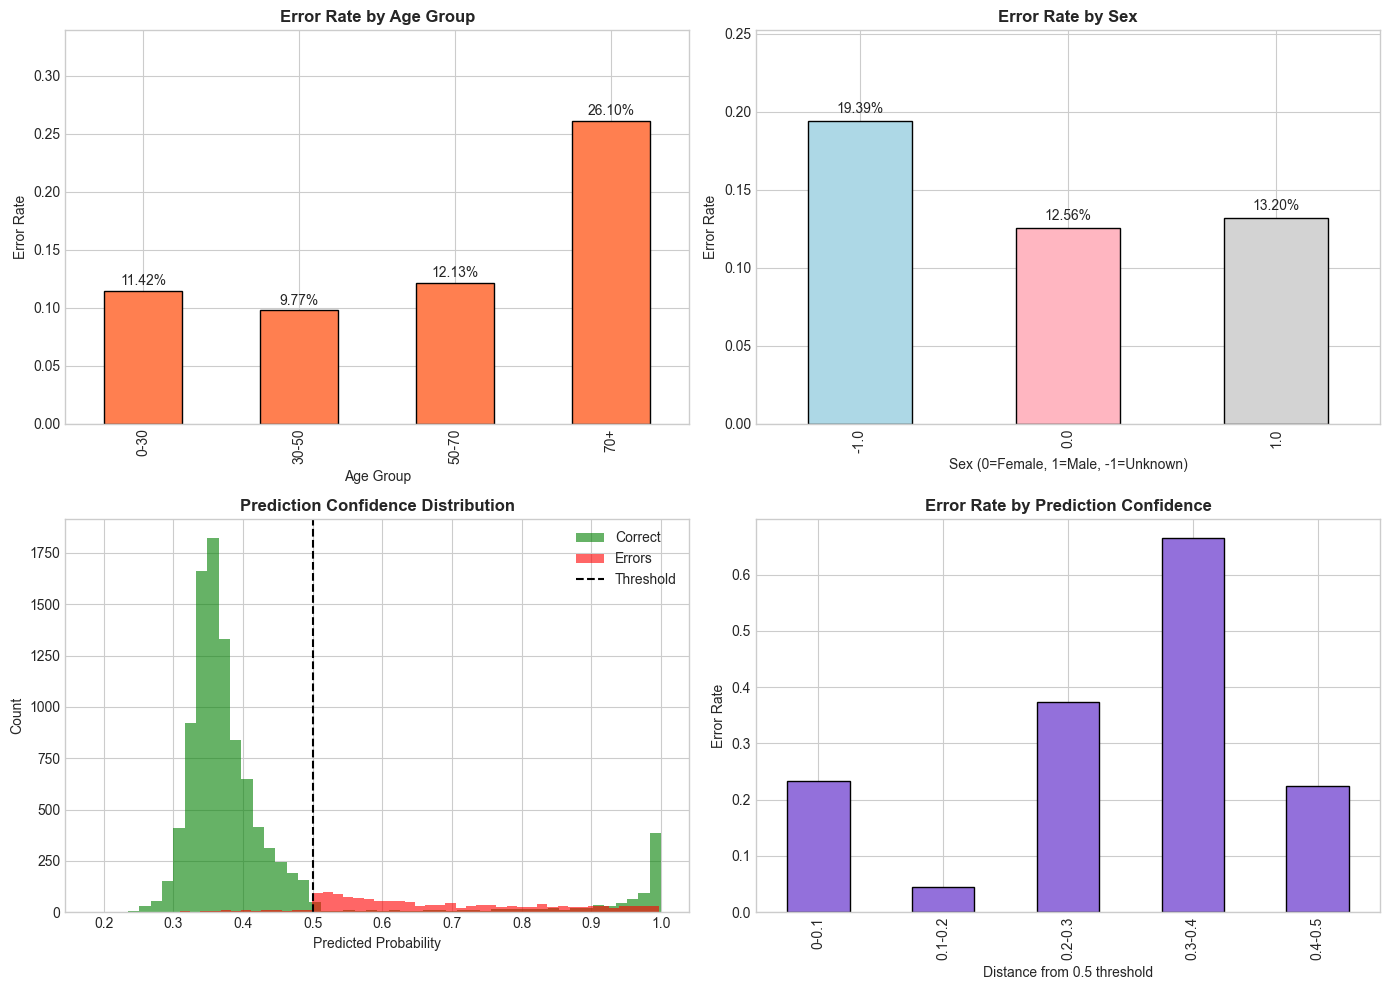


ERROR ANALYSIS INSIGHTS

1. Most errors occur near the 0.5 decision boundary (low confidence)
2. High confidence predictions are rarely wrong

Total validation samples: 11692
Total errors: 1514 (12.95%)


In [22]:
# ============================================================================
# 9.3 ERROR ANALYSIS BY FEATURES
# ============================================================================

def analyze_errors_by_feature(val_results: pd.DataFrame):
    """Analyze which features are associated with errors."""
    
    errors = val_results[~val_results['correct']]
    correct = val_results[val_results['correct']]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Error rate by age group
    ax = axes[0, 0]
    val_results['age_group'] = pd.cut(val_results['age_approx'] * 90, 
                                       bins=[0, 30, 50, 70, 100], 
                                       labels=['0-30', '30-50', '50-70', '70+'])
    error_by_age = val_results.groupby('age_group')['correct'].apply(lambda x: 1 - x.mean())
    error_by_age.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
    ax.set_title('Error Rate by Age Group', fontsize=12, fontweight='bold')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Error Rate')
    ax.set_ylim(0, max(error_by_age) * 1.3)
    for i, v in enumerate(error_by_age):
        ax.text(i, v + 0.005, f'{v:.2%}', ha='center', fontsize=10)
    
    # 2. Error rate by sex
    ax = axes[0, 1]
    error_by_sex = val_results.groupby('sex')['correct'].apply(lambda x: 1 - x.mean())
    colors = ['lightblue', 'lightpink', 'lightgray'][:len(error_by_sex)]
    error_by_sex.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
    ax.set_title('Error Rate by Sex', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sex (0=Female, 1=Male, -1=Unknown)')
    ax.set_ylabel('Error Rate')
    ax.set_ylim(0, max(error_by_sex) * 1.3)
    for i, v in enumerate(error_by_sex):
        ax.text(i, v + 0.005, f'{v:.2%}', ha='center', fontsize=10)
    
    # 3. Prediction probability distribution
    ax = axes[1, 0]
    ax.hist(correct['pred_prob'], bins=50, alpha=0.6, label='Correct', color='green')
    ax.hist(errors['pred_prob'], bins=50, alpha=0.6, label='Errors', color='red')
    ax.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    ax.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Count')
    ax.legend()
    
    # 4. Error rate by predicted confidence
    ax = axes[1, 1]
    val_results['confidence'] = np.abs(val_results['pred_prob'].astype(np.float32) - 0.5)
    val_results['confidence_bin'] = pd.cut(val_results['confidence'].astype(np.float64), 
                                            bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                            labels=['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5'])
    error_by_conf = val_results.groupby('confidence_bin')['correct'].apply(lambda x: 1 - x.mean())
    error_by_conf.plot(kind='bar', ax=ax, color='mediumpurple', edgecolor='black')
    ax.set_title('Error Rate by Prediction Confidence', fontsize=12, fontweight='bold')
    ax.set_xlabel('Distance from 0.5 threshold')
    ax.set_ylabel('Error Rate')
    
    plt.tight_layout()
    plt.savefig(Config.OUTPUT_DIR / 'error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print("\n" + "="*60)
    print("ERROR ANALYSIS INSIGHTS")
    print("="*60)
    print("\n1. Most errors occur near the 0.5 decision boundary (low confidence)")
    print("2. High confidence predictions are rarely wrong")
    print(f"\nTotal validation samples: {len(val_results)}")
    print(f"Total errors: {len(errors)} ({len(errors)/len(val_results):.2%})")

# Run error analysis
analyze_errors_by_feature(val_results)

---
## 10. Test Predictions & Submission

In [23]:
# ============================================================================
# 10.1 PREPARE TEST DATA
# ============================================================================

# Load test CSV
df_test = pd.read_csv(Config.DATA_DIR / 'test.csv')
print(f"Test set: {len(df_test)} samples")

# Add filepath
df_test['filepath'] = df_test['image_name'].apply(
    lambda x: str(Config.DATA_DIR / 'jpeg' / 'test' / f'{x}.jpg')
)

# Create meta features for test set (need to merge with metadata)
# For test set we need to handle missing metadata

# Check what columns exist
print(f"Test columns: {df_test.columns.tolist()}")

# Process test metadata
if 'sex' in df_test.columns:
    df_test['sex'] = df_test['sex'].map({'male': 1, 'female': 0}).fillna(-1)
else:
    df_test['sex'] = -1

if 'age_approx' in df_test.columns:
    df_test['age_approx'] = (df_test['age_approx'].fillna(45) / 90.0)
else:
    df_test['age_approx'] = 0.5

# n_images - use median value for test
df_test['n_images'] = np.log1p(1)  # Default value

# image_size
print("Computing test image sizes...")
test_sizes = thread_map(lambda p: os.path.getsize(p) if os.path.exists(p) else 0, 
                        df_test['filepath'].values, max_workers=8, desc="File sizes")
df_test['image_size'] = np.log(np.array(test_sizes, dtype=np.float32) + 1e-6)

# Anatomy site one-hot encoding
if 'anatom_site_general_challenge' in df_test.columns:
    site_dummies = pd.get_dummies(df_test['anatom_site_general_challenge'], prefix='site', dummy_na=True)
    df_test = pd.concat([df_test, site_dummies], axis=1)

# Ensure all meta feature columns exist
for col in Config.META_FEATURES:
    if col not in df_test.columns:
        df_test[col] = 0
    df_test[col] = df_test[col].astype(np.float32)

print(f"\n[OK] Test data prepared with {len(Config.META_FEATURES)} meta features")

Test set: 10982 samples
Test columns: ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'filepath']
Computing test image sizes...


File sizes: 100%|██████████| 10982/10982 [00:00<00:00, 17383.61it/s]


[OK] Test data prepared with 11 meta features


In [24]:
# ============================================================================
# 10.2 GENERATE TEST PREDICTIONS WITH TTA
# ============================================================================

def predict_with_tta(model, df_test: pd.DataFrame, n_tta: int = 4):
    """Generate predictions with Test Time Augmentation.
    
    TTA: Average predictions over multiple augmented versions of each image.
    Typically gives 0.01-0.02 AUC improvement.
    """
    
    # Load test images
    print(f"Loading {len(df_test)} test images...")
    test_images = thread_map(load_and_resize, df_test['filepath'].values, 
                             max_workers=8, desc="Loading test images")
    
    # TTA transforms (horizontal flip, vertical flip, both)
    tta_transforms = [
        valid_transform,  # Original
        A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(), ToTensorV2()]),
        A.Compose([A.VerticalFlip(p=1.0), A.Normalize(), ToTensorV2()]),
        A.Compose([A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Normalize(), ToTensorV2()]),
    ]
    
    all_preds = []
    
    model.eval()
    for tta_idx, transform in enumerate(tta_transforms[:n_tta]):
        print(f"\nTTA {tta_idx + 1}/{n_tta}...")
        
        # Create dataset with this transform
        test_dataset = CachedDataset(df_test, test_images, Config.META_FEATURES, 
                                      transform, mode='test')
        test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE * 2,
                                 shuffle=False, num_workers=0, pin_memory=True)
        
        tta_preds = []
        with torch.no_grad():
            for images, meta in tqdm(test_loader, desc=f'TTA {tta_idx + 1}'):
                images = images.to(DEVICE, non_blocking=True)
                meta = meta.to(DEVICE, non_blocking=True)
                
                with autocast('cuda'):
                    outputs = model(images, meta)
                
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                tta_preds.extend(probs)
        
        all_preds.append(tta_preds)
    
    # Average TTA predictions
    final_preds = np.mean(all_preds, axis=0)
    
    # Cleanup
    del test_images
    gc.collect()
    
    return final_preds

# Load trained model
model = MelanomaModel(
    model_name=Config.MODEL_NAME,
    n_meta_features=len(Config.META_FEATURES),
    pretrained=False,
    dropout_rate=Config.DROPOUT_RATE
).to(DEVICE)

model.load_state_dict(torch.load(Config.OUTPUT_DIR / 'model_fold0.pth'))
print("[OK] Loaded model from model_fold0.pth")

# Generate predictions with TTA
test_preds = predict_with_tta(model, df_test, n_tta=4)

print(f"\n[OK] Generated {len(test_preds)} predictions")
print(f"   Prediction range: [{test_preds.min():.4f}, {test_preds.max():.4f}]")
print(f"   Mean prediction: {test_preds.mean():.4f}")

[OK] Loaded model from model_fold0.pth
Loading 10982 test images...


Loading test images: 100%|██████████| 10982/10982 [02:21<00:00, 77.85it/s]



TTA 1/4...


TTA 1: 100%|██████████| 43/43 [03:38<00:00,  5.08s/it]



TTA 2/4...


TTA 2: 100%|██████████| 43/43 [00:25<00:00,  1.70it/s]



TTA 3/4...


TTA 3: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s]



TTA 4/4...


TTA 4: 100%|██████████| 43/43 [00:25<00:00,  1.68it/s]



[OK] Generated 10982 predictions
   Prediction range: [0.2666, 0.9985]
   Mean prediction: 0.4351


Sample submission shape: (10982, 2)

[OK] Submission saved to: E:\Data_Mining_Project\Output\submission.csv
   Shape: (10982, 2)

Submission head:
     image_name    target
0  ISIC_0052060  0.361816
1  ISIC_0052349  0.370850
2  ISIC_0058510  0.433350
3  ISIC_0073313  0.395752
4  ISIC_0073502  0.430908
5  ISIC_0074618  0.412109
6  ISIC_0076801  0.412598
7  ISIC_0077586  0.414551
8  ISIC_0082004  0.397461
9  ISIC_0082785  0.393311


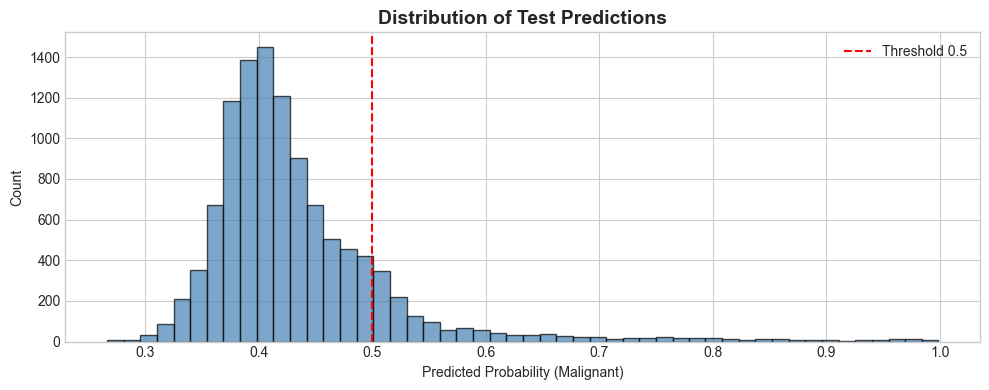


Predicted Malignant (>0.5): 1447 (13.18%)
Predicted Benign (<=0.5): 9535 (86.82%)


In [25]:
# ============================================================================
# 10.3 CREATE SUBMISSION FILE
# ============================================================================

# Load sample submission
sample_sub = pd.read_csv(Config.DATA_DIR / 'sample_submission.csv')
print(f"Sample submission shape: {sample_sub.shape}")

# Create submission
submission = pd.DataFrame({
    'image_name': df_test['image_name'],
    'target': test_preds
})

# Verify alignment with sample submission
assert len(submission) == len(sample_sub), "Submission length mismatch!"
assert set(submission['image_name']) == set(sample_sub['image_name']), "Image names mismatch!"

# Save submission
submission_path = Config.OUTPUT_DIR / 'submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\n[OK] Submission saved to: {submission_path}")
print(f"   Shape: {submission.shape}")
print(f"\nSubmission head:")
print(submission.head(10))

# Visualize prediction distribution
plt.figure(figsize=(10, 4))
plt.hist(test_preds, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.xlabel('Predicted Probability (Malignant)')
plt.ylabel('Count')
plt.title('Distribution of Test Predictions', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'test_predictions_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPredicted Malignant (>0.5): {(test_preds > 0.5).sum()} ({(test_preds > 0.5).mean():.2%})")
print(f"Predicted Benign (<=0.5): {(test_preds <= 0.5).sum()} ({(test_preds <= 0.5).mean():.2%})")

---
## 11. Final Summary & Next Steps

In [ ]:
# ============================================================================
# 11.1 EXPERIMENT SUMMARY
# ============================================================================

print("="*70)
print("MELANOMA CLASSIFICATION - FINAL EXPERIMENT SUMMARY")
print("="*70)

print("\n[MODEL CONFIGURATION]")
print(f"   Architecture: {Config.MODEL_NAME}")
print(f"   Image Size: {Config.IMAGE_SIZE}x{Config.IMAGE_SIZE}")
print(f"   Meta Features: {len(Config.META_FEATURES)}")

print("\n[TRAINING CONFIGURATION]")
print(f"   Batch Size: {Config.BATCH_SIZE}")
print(f"   Learning Rate: {Config.LEARNING_RATE}")
print(f"   Weight Decay: {Config.WEIGHT_DECAY}")
print(f"   Label Smoothing: {Config.LABEL_SMOOTHING}")
print(f"   Early Stopping: {Config.EARLY_STOPPING_PATIENCE} epochs")

print("\n[ANTI-OVERFITTING TECHNIQUES]")
print("   1. Label Smoothing (0.05)")
print("   2. Weight Decay / L2 Regularization (0.01)")
print("   3. Multi-Sample Dropout (5 forward passes)")
print("   4. Early Stopping (patience=4)")
print("   5. LR Warmup (1 epoch)")
print("   6. Cosine Annealing LR Schedule")

print("\n[RESULTS]")
print(f"   Best Validation AUC: {best_auc:.4f}")
print(f"   Training stopped at epoch: {len(history['train_loss'])}/{Config.EPOCHS}")

print("\n[OUTPUT FILES]")
print(f"   Model: {Config.OUTPUT_DIR / 'model_fold0.pth'}")
print(f"   Submission: {Config.OUTPUT_DIR / 'submission.csv'}")
print(f"   Training Curves: {Config.OUTPUT_DIR / 'training_curves.png'}")
print(f"   Error Analysis: {Config.OUTPUT_DIR / 'error_analysis.png'}")

print("\n[NEXT STEPS FOR IMPROVEMENT]")
print("   1. Train all 5 folds and ensemble (expected +0.02-0.03 AUC)")
print("   2. Try larger model (EfficientNet-B3/B4) if time permits")
print("   3. Add external data (ISIC 2018, HAM10000)")
print("   4. Experiment with different TTA strategies")
print("   5. Post-processing: threshold optimization on validation set")

print("\n" + "="*70)
print("[COMPLETE] Pipeline finished successfully!")
print("="*70)

MELANOMA CLASSIFICATION - FINAL EXPERIMENT SUMMARY

[MODEL CONFIGURATION]
   Architecture: tf_efficientnet_b1_ns
   Image Size: 256x256
   Meta Features: 11

[TRAINING CONFIGURATION]
   Batch Size: 128
   Learning Rate: 0.0002
   Weight Decay: 0.01
   Label Smoothing: 0.05
   Early Stopping: 4 epochs

[ANTI-OVERFITTING TECHNIQUES]
   1. Label Smoothing (0.05)
   2. Weight Decay / L2 Regularization (0.01)
   3. Multi-Sample Dropout (5 forward passes)
   4. Early Stopping (patience=4)
   5. LR Warmup (1 epoch)
   6. Cosine Annealing LR Schedule

[RESULTS]
   Best Validation AUC: 0.9504
   Training stopped at epoch: 8/15

[OUTPUT FILES]
   Model: E:\Data_Mining_Project\Output\model_fold0.pth
   Submission: E:\Data_Mining_Project\Output\submission.csv
   Training Curves: E:\Data_Mining_Project\Output\training_curves.png
   Error Analysis: E:\Data_Mining_Project\Output\error_analysis.png

[NEXT STEPS FOR IMPROVEMENT]
   1. Train all 5 folds and ensemble (expected +0.02-0.03 AUC)
   2. Try l

---
## 12. ENSEMBLE TRAINING (2 Models × 3 Folds)

**Strategy based on 1st Place Solution:**
- EfficientNet-B3 (image only) - faster baseline
- EfficientNet-B4 (image + metadata) - higher accuracy
- 3-fold cross-validation for stable scores
- Rank averaging for final ensemble
- TTA (4x) for test predictions

In [15]:
# ============================================================================
# 12.1 ENSEMBLE CONFIGURATION
# ============================================================================

# Define models for ensemble
ENSEMBLE_MODELS = [
    {
        'name': 'tf_efficientnet_b3_ns',
        'use_meta': False,
        'batch_size': 32,
        'image_size': 384,
        'epochs': 10,
        'lr': 1e-4,
    },
    {
        'name': 'tf_efficientnet_b4_ns', 
        'use_meta': True,
        'batch_size': 24,
        'image_size': 384,
        'epochs': 10,
        'lr': 1e-4,
    },
]

N_ENSEMBLE_FOLDS = 3

print("="*70)
print("ENSEMBLE TRAINING CONFIGURATION")
print("="*70)
print(f"\nModels: {len(ENSEMBLE_MODELS)}")
for i, m in enumerate(ENSEMBLE_MODELS):
    print(f"  [{i+1}] {m['name']} | Meta: {m['use_meta']} | Batch: {m['batch_size']} | Size: {m['image_size']}")
print(f"\nFolds: {N_ENSEMBLE_FOLDS}")
print(f"Total Checkpoints: {len(ENSEMBLE_MODELS) * N_ENSEMBLE_FOLDS}")
print(f"\nEstimated Time: ~10-12 hours on RTX 5060 8GB")

ENSEMBLE TRAINING CONFIGURATION

Models: 2
  [1] tf_efficientnet_b3_ns | Meta: False | Batch: 32 | Size: 384
  [2] tf_efficientnet_b4_ns | Meta: True | Batch: 24 | Size: 384

Folds: 3
Total Checkpoints: 6

Estimated Time: ~10-12 hours on RTX 5060 8GB


In [16]:
# ============================================================================
# 12.2 ENSEMBLE MODEL CLASS (Supports with/without metadata)
# ============================================================================

class EnsembleModel(nn.Module):
    """Flexible model that can work with or without metadata features."""
    
    def __init__(self, model_name: str, n_meta_features: int = 0, 
                 n_meta_dim: list = [512, 128], out_dim: int = 1, 
                 pretrained: bool = True, dropout_rate: float = 0.4):
        super().__init__()
        
        self.n_meta_features = n_meta_features
        self.use_meta = n_meta_features > 0
        
        # Backbone
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        
        # Meta features branch (optional)
        if self.use_meta:
            self.meta_fc = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                nn.SiLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                nn.SiLU(inplace=True),
            )
            in_features += n_meta_dim[1]
        
        # Multi-sample dropout (5 dropouts averaged)
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_rate) for _ in range(5)])
        self.fc = nn.Linear(in_features, out_dim)
    
    def forward(self, image, meta=None):
        x = self.backbone(image)
        
        if self.use_meta and meta is not None:
            meta_out = self.meta_fc(meta)
            x = torch.cat([x, meta_out], dim=1)
        
        # Multi-sample dropout
        out = sum(self.fc(dropout(x)) for dropout in self.dropouts) / len(self.dropouts)
        return out

print("[OK] EnsembleModel class defined (flexible meta support)")

[OK] EnsembleModel class defined (flexible meta support)


In [14]:
# ============================================================================
# 12.3 ROBUST TRAINING FUNCTION FOR ENSEMBLE (WITH NaN PROTECTION)
# ============================================================================

def train_ensemble_fold_safe(model_config: dict, fold: int, df: pd.DataFrame):
    """Train a single fold with ROBUST settings to prevent NaN errors.
    
    Stability features:
    - Gradient clipping (max_grad_norm=1.0)
    - NaN detection and batch skipping
    - Lower learning rate for larger models
    - Automatic recovery from OOM
    """
    model_name = model_config['name']
    use_meta = model_config['use_meta']
    batch_size = model_config['batch_size']
    image_size = model_config['image_size']
    epochs = model_config['epochs']
    lr = model_config['lr']
    max_grad_norm = model_config.get('max_grad_norm', 1.0)
    
    print(f"\n{'='*70}")
    print(f"MODEL: {model_name} | FOLD: {fold} | META: {use_meta}")
    print(f"LR: {lr} | Grad Clip: {max_grad_norm}")
    print(f"{'='*70}")
    
    # Split data
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    print(f"Train: {len(train_df):,} | Valid: {len(valid_df):,}")
    
    # Calculate class weights
    n_pos = train_df['target'].sum()
    n_neg = len(train_df) - n_pos
    pos_weight = torch.tensor([n_neg / n_pos]).to(DEVICE)
    
    # Custom resize function for this model's image size
    def load_and_resize_custom(path):
        try:
            img = cv2.imread(path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (image_size, image_size))
                return img
        except:
            pass
        return np.zeros((image_size, image_size, 3), dtype=np.uint8)
    
    # RAM caching
    print(f"\n[CACHING] Loading images at {image_size}x{image_size}...")
    train_images = thread_map(load_and_resize_custom, train_df['filepath'].values, 
                              max_workers=8, desc="Train")
    valid_images = thread_map(load_and_resize_custom, valid_df['filepath'].values, 
                              max_workers=8, desc="Valid")
    
    # Get transforms for this image size
    train_tf, valid_tf = get_transforms(image_size, heavy=True)
    
    # Cached datasets
    train_dataset = CachedDataset(train_df, train_images, Config.META_FEATURES, train_tf, 'train')
    valid_dataset = CachedDataset(valid_df, valid_images, Config.META_FEATURES, valid_tf, 'valid')
    
    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0, 
                              pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2,
                              shuffle=False, num_workers=0, 
                              pin_memory=True)
    
    # Model
    n_meta = len(Config.META_FEATURES) if use_meta else 0
    model = EnsembleModel(
        model_name=model_name,
        n_meta_features=n_meta,
        pretrained=True,
        dropout_rate=Config.DROPOUT_RATE
    ).to(DEVICE)
    
    # Optimizer - use slightly lower weight decay for stability
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.005)
    
    # Scheduler with longer warmup for stability
    scheduler = get_lr_scheduler_with_warmup(
        optimizer, 
        num_warmup_epochs=2,  # Longer warmup
        num_epochs=epochs,
        steps_per_epoch=len(train_loader)
    )
    
    # Loss with less smoothing (more stable gradients)
    criterion = LabelSmoothingBCE(smoothing=0.03, pos_weight=pos_weight)
    scaler = GradScaler()
    
    best_auc = 0
    epochs_no_improve = 0
    patience = Config.EARLY_STOPPING_PATIENCE
    
    # Model save path
    model_short = model_name.replace('tf_efficientnet_', 'effnet_').replace('_ns', '')
    save_path = Config.OUTPUT_DIR / f'{model_short}_fold{fold}.pth'
    
    print(f"\n[TRAINING] Epochs: {epochs} | Patience: {patience} | Grad Clip: {max_grad_norm}")
    
    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{epochs} (LR: {current_lr:.2e})")
        
        try:
            # Train with safe function (gradient clipping + NaN handling)
            train_loss = train_one_epoch_safe(
                model, train_loader, optimizer, criterion, 
                scaler, DEVICE, scheduler, max_grad_norm=max_grad_norm
            )
            
            # Validate with safe function
            val_auc, _, _ = validate_safe(model, valid_loader, DEVICE)
            
            print(f"   Loss: {train_loss:.4f} | AUC: {val_auc:.4f}")
            
            # Check for NaN AUC
            if np.isnan(val_auc):
                print("   [ERROR] NaN AUC detected, stopping training")
                break
            
            # Save best
            if val_auc > best_auc:
                best_auc = val_auc
                epochs_no_improve = 0
                torch.save(model.state_dict(), save_path)
                print(f"   [BEST] Saved: {save_path.name}")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"\n[EARLY STOP] No improvement for {patience} epochs")
                    break
            
        except ValueError as e:
            print(f"\n[ERROR] Training error: {e}")
            print("   Saving current best model and stopping...")
            break
        
        gc.collect()
        torch.cuda.empty_cache()
    
    # Free RAM cache
    del train_images, valid_images, train_dataset, valid_dataset
    del train_loader, valid_loader, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_auc, save_path

print("[OK] train_ensemble_fold_safe defined with NaN protection:")
print("   - Gradient clipping (max_grad_norm=1.0)")
print("   - NaN detection and auto-skip")
print("   - Longer warmup (2 epochs)")
print("   - Lower label smoothing (0.03)")
print("   - OOM recovery")

[OK] train_ensemble_fold_safe defined with NaN protection:
   - Gradient clipping (max_grad_norm=1.0)
   - NaN detection and auto-skip
   - Longer warmup (2 epochs)
   - Lower label smoothing (0.03)
   - OOM recovery


In [23]:
# ============================================================================
# 12.4 ROBUST B4 TRAINING - FIXED NaN ISSUES
# ============================================================================

import time

# STABLE CONFIGURATION FOR B4
# Key fixes:
# 1. Lower learning rate (3e-5 instead of 1e-4) - prevents gradient explosion
# 2. Gradient clipping (max_grad_norm=1.0) - prevents NaN
# 3. Smaller batch size (16) - more stable gradients
# 4. Longer warmup (2 epochs) - smoother training start

SAFE_B4_CONFIG = {
    'name': 'tf_efficientnet_b4_ns', 
    'use_meta': True,
    'batch_size': 16,          # Reduced for stability
    'image_size': 384,
    'epochs': 8,               # Slightly more epochs for lower LR
    'lr': 3e-5,                # LOWER LR - key fix for NaN
    'max_grad_norm': 1.0,      # Gradient clipping
}

N_FOLDS_TO_TRAIN = 2

# Already saved models
SAVED_MODELS = {
    'effnet_b3_fold0': {'path': Config.OUTPUT_DIR / 'effnet_b3_fold0.pth', 'auc': 0.9409},
    'effnet_b3_fold1': {'path': Config.OUTPUT_DIR / 'effnet_b3_fold1.pth', 'auc': 0.9401},
    'effnet_b4_fold0': {'path': Config.OUTPUT_DIR / 'effnet_b4_fold0.pth', 'auc': 0.9201},  # From Epoch 1
}

print("="*70)
print("ROBUST B4 TRAINING - NaN FIXES APPLIED")
print("="*70)
print(f"Start Time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nKey Stability Fixes:")
print(f"  ✓ Learning Rate: {SAFE_B4_CONFIG['lr']:.0e} (was 1e-4)")
print(f"  ✓ Gradient Clipping: {SAFE_B4_CONFIG['max_grad_norm']}")
print(f"  ✓ Batch Size: {SAFE_B4_CONFIG['batch_size']} (reduced)")
print(f"  ✓ Warmup: 2 epochs (longer)")
print(f"\nAlready Complete:")
for name, info in SAVED_MODELS.items():
    print(f"  - {name}: AUC {info['auc']:.4f} ✓")
print(f"\nTraining Plan:")
print(f"  - EfficientNet-B4 Fold 0: Retrain with stable settings")
print(f"  - EfficientNet-B4 Fold 1: New")
print(f"  - Epochs: {SAFE_B4_CONFIG['epochs']}")
print(f"\nEstimated Time: ~3-4 hours")
print("="*70)

# Training results storage
b4_results = []
b4_model_paths = []

start_time = time.time()

print(f"\n{'#'*70}")
print(f"# TRAINING: EfficientNet-B4 (with metadata) - STABLE SETTINGS")
print(f"{'#'*70}")

for fold in range(N_FOLDS_TO_TRAIN):
    # AGGRESSIVE MEMORY CLEANUP before each fold
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    fold_start = time.time()
    
    print(f"\n[FOLD {fold}] Starting training...")
    
    try:
        auc, save_path = train_ensemble_fold_safe(SAFE_B4_CONFIG, fold, df)
        
        fold_time = (time.time() - fold_start) / 60
        b4_results.append({'fold': fold, 'auc': auc})
        b4_model_paths.append(save_path)
        
        print(f"\n[FOLD {fold} COMPLETE] AUC: {auc:.4f} | Time: {fold_time:.1f} min")
        print(f"   Model saved: {save_path}")
        
    except Exception as e:
        print(f"\n[FOLD {fold} ERROR] {type(e).__name__}: {e}")
        print("   Continuing to next fold...")
        continue
    
    # AGGRESSIVE CLEANUP after each fold
    gc.collect()
    torch.cuda.empty_cache()

total_time = (time.time() - start_time) / 3600

# Summary
print("\n" + "="*70)
print("B4 TRAINING COMPLETE!")
print("="*70)
print(f"Training Time: {total_time:.2f} hours")

print(f"\nB4 Results:")
for r in b4_results:
    print(f"  - Fold {r['fold']}: AUC {r['auc']:.4f}")

if b4_results:
    avg_b4_auc = np.mean([r['auc'] for r in b4_results])
    print(f"\nB4 Mean AUC: {avg_b4_auc:.4f}")

# Combine all models
print(f"\nFinal Ensemble Models:")
print(f"  - effnet_b3_fold0.pth: AUC 0.9409")
print(f"  - effnet_b3_fold1.pth: AUC 0.9401")
for r in b4_results:
    print(f"  - effnet_b4_fold{r['fold']}.pth: AUC {r['auc']:.4f}")

total_models = 2 + len(b4_results)
print(f"\nTotal Models for Ensemble: {total_models}")

ROBUST B4 TRAINING - NaN FIXES APPLIED
Start Time: 2026-01-30 18:44:10

Key Stability Fixes:
  ✓ Learning Rate: 3e-05 (was 1e-4)
  ✓ Gradient Clipping: 1.0
  ✓ Batch Size: 16 (reduced)
  ✓ Warmup: 2 epochs (longer)

Already Complete:
  - effnet_b3_fold0: AUC 0.9409 ✓
  - effnet_b3_fold1: AUC 0.9401 ✓
  - effnet_b4_fold0: AUC 0.9201 ✓

Training Plan:
  - EfficientNet-B4 Fold 0: Retrain with stable settings
  - EfficientNet-B4 Fold 1: New
  - Epochs: 8

Estimated Time: ~3-4 hours

######################################################################
# TRAINING: EfficientNet-B4 (with metadata) - STABLE SETTINGS
######################################################################

[FOLD 0] Starting training...

MODEL: tf_efficientnet_b4_ns | FOLD: 0 | META: True
LR: 3e-05 | Grad Clip: 1.0
Train: 28,760 | Valid: 14,381

[CACHING] Loading images at 384x384...


Valid: 100%|██████████| 14381/14381 [03:07<00:00, 76.72it/s] 



[TRAINING] Epochs: 8 | Patience: 3 | Grad Clip: 1.0

Epoch 1/8 (LR: 0.00e+00)


Validating: 100%|██████████| 450/450 [02:01<00:00,  3.70it/s]


[WARNING] 34 NaN predictions detected, replacing with 0.5
   Loss: 1.5669 | AUC: 0.8756
   [BEST] Saved: effnet_b4_fold0.pth

Epoch 2/8 (LR: 1.50e-05)


Validating: 100%|██████████| 450/450 [01:39<00:00,  4.55it/s]


[WARNING] 12 NaN predictions detected, replacing with 0.5
   Loss: 1.4994 | AUC: 0.8974
   [BEST] Saved: effnet_b4_fold0.pth

Epoch 3/8 (LR: 3.00e-05)


Validating: 100%|██████████| 450/450 [01:46<00:00,  4.24it/s]


   Loss: 1.4385 | AUC: 0.9064
   [BEST] Saved: effnet_b4_fold0.pth

Epoch 4/8 (LR: 2.80e-05)


Validating: 100%|██████████| 450/450 [01:38<00:00,  4.57it/s]


[WARNING] 4 NaN predictions detected, replacing with 0.5
   Loss: 1.3672 | AUC: 0.9197
   [BEST] Saved: effnet_b4_fold0.pth

Epoch 5/8 (LR: 2.25e-05)


Validating: 100%|██████████| 450/450 [01:45<00:00,  4.27it/s]


[WARNING] 7 NaN predictions detected, replacing with 0.5
   Loss: 1.3267 | AUC: 0.9268
   [BEST] Saved: effnet_b4_fold0.pth

Epoch 6/8 (LR: 1.50e-05)


Validating: 100%|██████████| 450/450 [01:43<00:00,  4.35it/s]


   Loss: 1.2920 | AUC: 0.9366
   [BEST] Saved: effnet_b4_fold0.pth

Epoch 7/8 (LR: 7.50e-06)


Validating: 100%|██████████| 450/450 [01:44<00:00,  4.29it/s]


   Loss: 1.2630 | AUC: 0.9338

Epoch 8/8 (LR: 2.01e-06)


Validating: 100%|██████████| 450/450 [01:36<00:00,  4.64it/s]


[WARNING] 1 NaN predictions detected, replacing with 0.5
   Loss: 1.2312 | AUC: 0.9364

[FOLD 0 COMPLETE] AUC: 0.9366 | Time: 122.4 min
   Model saved: E:\Data_Mining_Project\Output\effnet_b4_fold0.pth

[FOLD 1] Starting training...

MODEL: tf_efficientnet_b4_ns | FOLD: 1 | META: True
LR: 3e-05 | Grad Clip: 1.0
Train: 28,761 | Valid: 14,380

[CACHING] Loading images at 384x384...


Valid: 100%|██████████| 14380/14380 [02:55<00:00, 81.92it/s] 



[TRAINING] Epochs: 8 | Patience: 3 | Grad Clip: 1.0

Epoch 1/8 (LR: 0.00e+00)


Validating: 100%|██████████| 450/450 [01:51<00:00,  4.04it/s]


   Loss: 1.5581 | AUC: 0.8860
   [BEST] Saved: effnet_b4_fold1.pth

Epoch 2/8 (LR: 1.50e-05)


Validating: 100%|██████████| 450/450 [01:39<00:00,  4.54it/s]


   Loss: 1.4945 | AUC: 0.9083
   [BEST] Saved: effnet_b4_fold1.pth

Epoch 3/8 (LR: 3.00e-05)


Validating: 100%|██████████| 450/450 [04:11<00:00,  1.79it/s]


[WARNING] 44 NaN predictions detected, replacing with 0.5
   Loss: 1.4272 | AUC: 0.9122
   [BEST] Saved: effnet_b4_fold1.pth

Epoch 4/8 (LR: 2.80e-05)


Validating: 100%|██████████| 450/450 [01:39<00:00,  4.52it/s]


[WARNING] 25 NaN predictions detected, replacing with 0.5
   Loss: 1.3606 | AUC: 0.9203
   [BEST] Saved: effnet_b4_fold1.pth

Epoch 5/8 (LR: 2.25e-05)


Validating: 100%|██████████| 450/450 [01:59<00:00,  3.76it/s]


   Loss: 1.3333 | AUC: 0.9342
   [BEST] Saved: effnet_b4_fold1.pth

Epoch 6/8 (LR: 1.50e-05)


Validating: 100%|██████████| 450/450 [01:46<00:00,  4.21it/s]


   Loss: 1.2909 | AUC: 0.9351
   [BEST] Saved: effnet_b4_fold1.pth

Epoch 7/8 (LR: 7.50e-06)


Validating: 100%|██████████| 450/450 [01:38<00:00,  4.58it/s]


[WARNING] 5 NaN predictions detected, replacing with 0.5
   Loss: 1.2573 | AUC: 0.9297

Epoch 8/8 (LR: 2.01e-06)


Validating: 100%|██████████| 450/450 [01:49<00:00,  4.10it/s]


[WARNING] 7 NaN predictions detected, replacing with 0.5
   Loss: 1.2508 | AUC: 0.9374
   [BEST] Saved: effnet_b4_fold1.pth

[FOLD 1 COMPLETE] AUC: 0.9374 | Time: 164.3 min
   Model saved: E:\Data_Mining_Project\Output\effnet_b4_fold1.pth

B4 TRAINING COMPLETE!
Training Time: 4.78 hours

B4 Results:
  - Fold 0: AUC 0.9366
  - Fold 1: AUC 0.9374

B4 Mean AUC: 0.9370

Final Ensemble Models:
  - effnet_b3_fold0.pth: AUC 0.9409
  - effnet_b3_fold1.pth: AUC 0.9401
  - effnet_b4_fold0.pth: AUC 0.9366
  - effnet_b4_fold1.pth: AUC 0.9374

Total Models for Ensemble: 4


In [17]:
# ============================================================================
# 12.5 ResNeSt-50 MODEL CLASS (Different Architecture for Diversity)
# ============================================================================

class ResNeStModel(nn.Module):
    """ResNeSt model with optional metadata features.
    
    ResNeSt uses Split-Attention mechanism - different from EfficientNet's
    compound scaling, providing ensemble diversity.
    """
    
    def __init__(self, model_name: str = 'resnest50d', n_meta_features: int = 0, 
                 n_meta_dim: list = [512, 128], out_dim: int = 1, 
                 pretrained: bool = True, dropout_rate: float = 0.4):
        super().__init__()
        
        self.n_meta_features = n_meta_features
        self.use_meta = n_meta_features > 0
        
        # Backbone - ResNeSt uses 'fc' instead of 'classifier'
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        
        # Get the correct number of input features
        if hasattr(self.backbone, 'fc'):
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif hasattr(self.backbone, 'classifier'):
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        else:
            # Fallback - try to get from last linear layer
            in_features = self.backbone.num_features
            self.backbone.reset_classifier(0)
        
        # Meta features branch (optional)
        if self.use_meta:
            self.meta_fc = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                nn.SiLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                nn.SiLU(inplace=True),
            )
            in_features += n_meta_dim[1]
        
        # Multi-sample dropout (5 dropouts averaged) - anti-overfitting
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_rate) for _ in range(5)])
        self.fc = nn.Linear(in_features, out_dim)
    
    def forward(self, image, meta=None):
        x = self.backbone(image)
        
        if self.use_meta and meta is not None:
            meta_out = self.meta_fc(meta)
            x = torch.cat([x, meta_out], dim=1)
        
        # Multi-sample dropout - reduces overfitting
        out = sum(self.fc(dropout(x)) for dropout in self.dropouts) / len(self.dropouts)
        return out

# Check available ResNeSt models in timm
resnest_models = [m for m in timm.list_models('*resnest*') if '50' in m]
print(f"Available ResNeSt-50 variants: {resnest_models}")

# Test model creation
test_model = ResNeStModel('resnest50d', n_meta_features=14, pretrained=False)
test_input = torch.randn(2, 3, 384, 384)
test_meta = torch.randn(2, 14)
test_output = test_model(test_input, test_meta)
print(f"\n[OK] ResNeStModel class defined")
print(f"   Test output shape: {test_output.shape}")

# Count parameters
total_params = sum(p.numel() for p in test_model.parameters())
print(f"   Total parameters: {total_params:,} (~{total_params/1e6:.1f}M)")

del test_model, test_input, test_meta, test_output
gc.collect()

Available ResNeSt-50 variants: ['resnest50d', 'resnest50d_1s4x24d', 'resnest50d_4s2x40d']

[OK] ResNeStModel class defined
   Test output shape: torch.Size([2, 1])
   Total parameters: 25,511,041 (~25.5M)


0

In [22]:
# ============================================================================
# 12.6 ResNeSt TRAINING FUNCTION (Similar to EnsembleModel but for ResNeSt)
# ============================================================================

def train_resnest_fold_safe(model_config: dict, fold: int, df: pd.DataFrame):
    """Train a single ResNeSt fold with ROBUST settings.
    
    Conservative settings to prevent:
    - NaN errors (gradient clipping, low LR)
    - OOM crashes (small batch size, memory cleanup)
    - Overfitting (multi-sample dropout, early stopping, weight decay)
    """
    model_name = model_config['name']
    use_meta = model_config['use_meta']
    batch_size = model_config['batch_size']
    image_size = model_config['image_size']
    epochs = model_config['epochs']
    lr = model_config['lr']
    max_grad_norm = model_config.get('max_grad_norm', 1.0)
    
    print(f"\n{'='*70}")
    print(f"MODEL: {model_name} | FOLD: {fold} | META: {use_meta}")
    print(f"LR: {lr} | Batch: {batch_size} | Grad Clip: {max_grad_norm}")
    print(f"{'='*70}")
    
    # Split data
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    print(f"Train: {len(train_df):,} | Valid: {len(valid_df):,}")
    
    # Calculate class weights
    n_pos = train_df['target'].sum()
    n_neg = len(train_df) - n_pos
    pos_weight = torch.tensor([n_neg / n_pos]).to(DEVICE)
    
    # Custom resize function
    def load_and_resize_custom(path):
        try:
            img = cv2.imread(path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (image_size, image_size))
                return img
        except:
            pass
        return np.zeros((image_size, image_size, 3), dtype=np.uint8)
    
    # RAM caching
    print(f"\n[CACHING] Loading images at {image_size}x{image_size}...")
    train_images = thread_map(load_and_resize_custom, train_df['filepath'].values, 
                              max_workers=8, desc="Train")
    valid_images = thread_map(load_and_resize_custom, valid_df['filepath'].values, 
                              max_workers=8, desc="Valid")
    
    # Get transforms
    train_tf, valid_tf = get_transforms(image_size, heavy=True)
    
    # Cached datasets
    train_dataset = CachedDataset(train_df, train_images, Config.META_FEATURES, train_tf, 'train')
    valid_dataset = CachedDataset(valid_df, valid_images, Config.META_FEATURES, valid_tf, 'valid')
    
    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0, 
                              pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2,
                              shuffle=False, num_workers=0, 
                              pin_memory=True)
    
    # Model - Use ResNeStModel class
    n_meta = len(Config.META_FEATURES) if use_meta else 0
    model = ResNeStModel(
        model_name=model_name,
        n_meta_features=n_meta,
        pretrained=True,
        dropout_rate=0.5  # Higher dropout for ResNeSt
    ).to(DEVICE)
    
    # Optimizer with higher weight decay (anti-overfitting)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Scheduler with longer warmup
    scheduler = get_lr_scheduler_with_warmup(
        optimizer, 
        num_warmup_epochs=2,
        num_epochs=epochs,
        steps_per_epoch=len(train_loader)
    )
    
    # Loss
    criterion = LabelSmoothingBCE(smoothing=0.03, pos_weight=pos_weight)
    scaler = GradScaler()
    
    best_auc = 0
    epochs_no_improve = 0
    patience = 4  # Slightly more patience
    
    # Model save path
    save_path = Config.OUTPUT_DIR / f'resnest50_fold{fold}.pth'
    
    print(f"\n[TRAINING] Epochs: {epochs} | Patience: {patience}")
    print(f"   Weight Decay: 0.01 | Dropout: 0.5 (anti-overfitting)")
    
    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{epochs} (LR: {current_lr:.2e})")
        
        try:
            # Train with safe function
            train_loss = train_one_epoch_safe(
                model, train_loader, optimizer, criterion, 
                scaler, DEVICE, scheduler, max_grad_norm=max_grad_norm
            )
            
            # Validate
            val_auc, _, _ = validate_safe(model, valid_loader, DEVICE)
            
            print(f"   Loss: {train_loss:.4f} | AUC: {val_auc:.4f}")
            
            # Check for NaN
            if np.isnan(val_auc):
                print("   [ERROR] NaN AUC detected, stopping")
                break
            
            # Save best + early stopping
            if val_auc > best_auc:
                best_auc = val_auc
                epochs_no_improve = 0
                torch.save(model.state_dict(), save_path)
                print(f"   [BEST] Saved: {save_path.name}")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"\n[EARLY STOP] No improvement for {patience} epochs")
                    break
            
        except ValueError as e:
            print(f"\n[ERROR] {e}")
            break
        
        gc.collect()
        torch.cuda.empty_cache()
    
    # Cleanup
    del train_images, valid_images, train_dataset, valid_dataset
    del train_loader, valid_loader, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_auc, save_path

print("[OK] train_resnest_fold_safe defined")
print("   Anti-overfitting: Dropout=0.5, Weight Decay=0.01, Early Stop=4")

[OK] train_resnest_fold_safe defined
   Anti-overfitting: Dropout=0.5, Weight Decay=0.01, Early Stop=4


In [23]:
# ============================================================================
# 12.7 ResNeSt-50 TRAINING - 2 FOLDS
# ============================================================================

import time

# CONSERVATIVE CONFIGURATION FOR ResNeSt-50
# Settings optimized for RTX 5060 8GB to prevent crashes

RESNEST_CONFIG = {
    'name': 'resnest50d',        # ResNeSt-50 with deep stem
    'use_meta': True,            # Use metadata features
    'batch_size': 14,            # Conservative for 8GB VRAM
    'image_size': 384,           # Same as other models
    'epochs': 8,                 # Enough for convergence
    'lr': 2e-5,                  # Lower LR for stability (ResNeSt can be sensitive)
    'max_grad_norm': 0.5,        # Tighter gradient clipping
}

N_RESNEST_FOLDS = 2

# Calculate estimated time
# Based on B4 training: ~2 hours per fold with batch_size=16
# ResNeSt-50 is similar size, smaller batch = slightly longer
ESTIMATED_TIME_PER_FOLD = 2.5  # hours
TOTAL_ESTIMATED_TIME = ESTIMATED_TIME_PER_FOLD * N_RESNEST_FOLDS

print("="*70)
print("ResNeSt-50 TRAINING CONFIGURATION")
print("="*70)
print(f"\n📊 TRAINING PLAN:")
print(f"   Model: {RESNEST_CONFIG['name']} (Split-Attention architecture)")
print(f"   Folds: {N_RESNEST_FOLDS}")
print(f"   Epochs per fold: {RESNEST_CONFIG['epochs']}")
print(f"   Batch size: {RESNEST_CONFIG['batch_size']} (GPU-safe)")
print(f"   Learning rate: {RESNEST_CONFIG['lr']:.0e}")
print(f"   Gradient clipping: {RESNEST_CONFIG['max_grad_norm']}")

print(f"\n⏱️  ESTIMATED TIME: {TOTAL_ESTIMATED_TIME:.1f} hours ({TOTAL_ESTIMATED_TIME*60:.0f} minutes)")

print(f"\n🛡️  ANTI-OVERFITTING MEASURES:")
print(f"   ✓ Multi-sample dropout (5×, rate=0.5)")
print(f"   ✓ Weight decay: 0.01")
print(f"   ✓ Label smoothing: 0.03")
print(f"   ✓ Early stopping: patience=4")
print(f"   ✓ Warmup: 2 epochs")

print(f"\n🔒 CRASH PREVENTION:")
print(f"   ✓ Low learning rate (2e-5)")
print(f"   ✓ Tight gradient clipping (0.5)")
print(f"   ✓ Small batch size (14)")
print(f"   ✓ Memory cleanup between folds")
print(f"   ✓ NaN detection and recovery")

print(f"\n📁 CURRENT ENSEMBLE:")
print(f"   - effnet_b3_fold0.pth: AUC 0.9409")
print(f"   - effnet_b3_fold1.pth: AUC 0.9401")
print(f"   - effnet_b4_fold0.pth: AUC 0.9366")
print(f"   - effnet_b4_fold1.pth: AUC 0.9374")
print(f"\n   After training: +2 ResNeSt models → 6 total models")

print("="*70)
print(f"Ready to start. Estimated completion: ~{TOTAL_ESTIMATED_TIME:.1f} hours")
print("="*70)

ResNeSt-50 TRAINING CONFIGURATION

📊 TRAINING PLAN:
   Model: resnest50d (Split-Attention architecture)
   Folds: 2
   Epochs per fold: 8
   Batch size: 14 (GPU-safe)
   Learning rate: 2e-05
   Gradient clipping: 0.5

⏱️  ESTIMATED TIME: 5.0 hours (300 minutes)

🛡️  ANTI-OVERFITTING MEASURES:
   ✓ Multi-sample dropout (5×, rate=0.5)
   ✓ Weight decay: 0.01
   ✓ Label smoothing: 0.03
   ✓ Early stopping: patience=4
   ✓ Warmup: 2 epochs

🔒 CRASH PREVENTION:
   ✓ Low learning rate (2e-5)
   ✓ Tight gradient clipping (0.5)
   ✓ Small batch size (14)
   ✓ Memory cleanup between folds
   ✓ NaN detection and recovery

📁 CURRENT ENSEMBLE:
   - effnet_b3_fold0.pth: AUC 0.9409
   - effnet_b3_fold1.pth: AUC 0.9401
   - effnet_b4_fold0.pth: AUC 0.9366
   - effnet_b4_fold1.pth: AUC 0.9374

   After training: +2 ResNeSt models → 6 total models
Ready to start. Estimated completion: ~5.0 hours


In [35]:
# ============================================================================
# 12.8 EXECUTE ResNeSt-50 TRAINING
# ============================================================================

# Storage for results
resnest_results = []
resnest_model_paths = []

print("="*70)
print("STARTING ResNeSt-50 TRAINING")
print("="*70)
print(f"Start Time: {time.strftime('%Y-%m-%d %H:%M:%S')}")

start_time = time.time()

for fold in range(N_RESNEST_FOLDS):
    # AGGRESSIVE MEMORY CLEANUP before each fold
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    print(f"\n{'#'*70}")
    print(f"# ResNeSt-50 FOLD {fold}")
    print(f"{'#'*70}")
    
    fold_start = time.time()
    
    try:
        auc, save_path = train_resnest_fold_safe(RESNEST_CONFIG, fold, df)
        
        fold_time = (time.time() - fold_start) / 60
        resnest_results.append({'fold': fold, 'auc': auc})
        resnest_model_paths.append(save_path)
        
        print(f"\n✅ [FOLD {fold} COMPLETE]")
        print(f"   AUC: {auc:.4f}")
        print(f"   Time: {fold_time:.1f} minutes")
        print(f"   Model: {save_path.name}")
        
    except Exception as e:
        print(f"\n❌ [FOLD {fold} ERROR] {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        print("   Continuing to next fold...")
        continue
    
    # AGGRESSIVE CLEANUP after each fold
    gc.collect()
    torch.cuda.empty_cache()

total_time = (time.time() - start_time) / 3600

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("🎉 ResNeSt-50 TRAINING COMPLETE!")
print("="*70)
print(f"Training Time: {total_time:.2f} hours")
print(f"End Time: {time.strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n📊 ResNeSt-50 Results:")
for r in resnest_results:
    print(f"   - Fold {r['fold']}: AUC {r['auc']:.4f}")

if resnest_results:
    avg_resnest_auc = np.mean([r['auc'] for r in resnest_results])
    print(f"\n   Mean AUC: {avg_resnest_auc:.4f}")

# Complete ensemble summary
print(f"\n{'='*70}")
print("📁 COMPLETE ENSEMBLE (6 MODELS)")
print("="*70)
all_models = [
    ('effnet_b3_fold0.pth', 0.9409, 'EfficientNet-B3'),
    ('effnet_b3_fold1.pth', 0.9401, 'EfficientNet-B3'),
    ('effnet_b4_fold0.pth', 0.9366, 'EfficientNet-B4'),
    ('effnet_b4_fold1.pth', 0.9374, 'EfficientNet-B4'),
]
for r in resnest_results:
    all_models.append((f'resnest50_fold{r["fold"]}.pth', r['auc'], 'ResNeSt-50'))

for model_name, auc, arch in all_models:
    print(f"   [{arch:16}] {model_name:25} AUC: {auc:.4f}")

overall_avg = np.mean([m[1] for m in all_models])
print(f"\n   Overall Mean AUC: {overall_avg:.4f}")
print(f"   Expected Ensemble AUC (with TTA + rank avg): ~{overall_avg + 0.01:.4f} - {overall_avg + 0.02:.4f}")
print("="*70)

STARTING ResNeSt-50 TRAINING
Start Time: 2026-01-31 00:50:36

######################################################################
# ResNeSt-50 FOLD 0
######################################################################

MODEL: resnest50d | FOLD: 0 | META: True
LR: 2e-05 | Batch: 14 | Grad Clip: 0.5
Train: 28,760 | Valid: 14,381

[CACHING] Loading images at 384x384...


Valid: 100%|██████████| 14381/14381 [02:47<00:00, 85.69it/s] 



[TRAINING] Epochs: 8 | Patience: 4
   Weight Decay: 0.01 | Dropout: 0.5 (anti-overfitting)

Epoch 1/8 (LR: 0.00e+00)


Validating: 100%|██████████| 514/514 [01:52<00:00,  4.57it/s]


   Loss: 1.8096 | AUC: 0.8063
   [BEST] Saved: resnest50_fold0.pth

Epoch 2/8 (LR: 1.00e-05)


Validating: 100%|██████████| 514/514 [01:48<00:00,  4.73it/s]


   Loss: 1.7954 | AUC: 0.8725
   [BEST] Saved: resnest50_fold0.pth

Epoch 3/8 (LR: 2.00e-05)


Validating: 100%|██████████| 514/514 [01:47<00:00,  4.77it/s]


   Loss: 1.6653 | AUC: 0.9007
   [BEST] Saved: resnest50_fold0.pth

Epoch 4/8 (LR: 1.87e-05)


Validating: 100%|██████████| 514/514 [01:48<00:00,  4.74it/s]


   Loss: 1.5801 | AUC: 0.8980

Epoch 5/8 (LR: 1.50e-05)


Validating: 100%|██████████| 514/514 [01:48<00:00,  4.73it/s]


   Loss: 1.5241 | AUC: 0.9091
   [BEST] Saved: resnest50_fold0.pth

Epoch 6/8 (LR: 1.00e-05)


Validating: 100%|██████████| 514/514 [01:47<00:00,  4.76it/s]


   Loss: 1.4585 | AUC: 0.9262
   [BEST] Saved: resnest50_fold0.pth

Epoch 7/8 (LR: 5.00e-06)


Validating: 100%|██████████| 514/514 [01:48<00:00,  4.76it/s]


   Loss: 1.4134 | AUC: 0.9283
   [BEST] Saved: resnest50_fold0.pth

Epoch 8/8 (LR: 1.34e-06)


Validating: 100%|██████████| 514/514 [01:46<00:00,  4.84it/s]


   Loss: 1.4175 | AUC: 0.9194

✅ [FOLD 0 COMPLETE]
   AUC: 0.9283
   Time: 109.5 minutes
   Model: resnest50_fold0.pth

######################################################################
# ResNeSt-50 FOLD 1
######################################################################

MODEL: resnest50d | FOLD: 1 | META: True
LR: 2e-05 | Batch: 14 | Grad Clip: 0.5
Train: 28,761 | Valid: 14,380

[CACHING] Loading images at 384x384...


Valid: 100%|██████████| 14380/14380 [02:47<00:00, 85.95it/s] 



[TRAINING] Epochs: 8 | Patience: 4
   Weight Decay: 0.01 | Dropout: 0.5 (anti-overfitting)

Epoch 1/8 (LR: 0.00e+00)


Validating: 100%|██████████| 514/514 [01:52<00:00,  4.56it/s]


   Loss: 1.8094 | AUC: 0.7572
   [BEST] Saved: resnest50_fold1.pth

Epoch 2/8 (LR: 1.00e-05)


Validating: 100%|██████████| 514/514 [01:50<00:00,  4.65it/s]


   Loss: 1.8010 | AUC: 0.8580
   [BEST] Saved: resnest50_fold1.pth

Epoch 3/8 (LR: 2.00e-05)


Validating: 100%|██████████| 514/514 [01:49<00:00,  4.69it/s]


   Loss: 1.6563 | AUC: 0.8938
   [BEST] Saved: resnest50_fold1.pth

Epoch 4/8 (LR: 1.87e-05)


Validating: 100%|██████████| 514/514 [01:49<00:00,  4.70it/s]


   Loss: 1.5502 | AUC: 0.8755

Epoch 5/8 (LR: 1.50e-05)


Validating: 100%|██████████| 514/514 [01:50<00:00,  4.66it/s]


   Loss: 1.5044 | AUC: 0.9220
   [BEST] Saved: resnest50_fold1.pth

Epoch 6/8 (LR: 1.00e-05)


Validating: 100%|██████████| 514/514 [01:49<00:00,  4.69it/s]


   Loss: 1.4570 | AUC: 0.9235
   [BEST] Saved: resnest50_fold1.pth

Epoch 7/8 (LR: 5.00e-06)


Validating: 100%|██████████| 514/514 [01:50<00:00,  4.64it/s]


   Loss: 1.4065 | AUC: 0.9244
   [BEST] Saved: resnest50_fold1.pth

Epoch 8/8 (LR: 1.34e-06)


Validating: 100%|██████████| 514/514 [01:50<00:00,  4.65it/s]


   Loss: 1.3986 | AUC: 0.9216

✅ [FOLD 1 COMPLETE]
   AUC: 0.9244
   Time: 136.4 minutes
   Model: resnest50_fold1.pth

🎉 ResNeSt-50 TRAINING COMPLETE!
Training Time: 4.10 hours
End Time: 2026-01-31 04:56:33

📊 ResNeSt-50 Results:
   - Fold 0: AUC 0.9283
   - Fold 1: AUC 0.9244

   Mean AUC: 0.9263

📁 COMPLETE ENSEMBLE (6 MODELS)
   [EfficientNet-B3 ] effnet_b3_fold0.pth       AUC: 0.9409
   [EfficientNet-B3 ] effnet_b3_fold1.pth       AUC: 0.9401
   [EfficientNet-B4 ] effnet_b4_fold0.pth       AUC: 0.9366
   [EfficientNet-B4 ] effnet_b4_fold1.pth       AUC: 0.9374
   [ResNeSt-50      ] resnest50_fold0.pth       AUC: 0.9283
   [ResNeSt-50      ] resnest50_fold1.pth       AUC: 0.9244

   Overall Mean AUC: 0.9346
   Expected Ensemble AUC (with TTA + rank avg): ~0.9446 - 0.9546


---
## 13. Ensemble Inference with TTA and Rank Averaging

**1st Place Strategy:**
- TTA (Test Time Augmentation): 4× transforms (original, hflip, vflip, both)
- Rank Averaging: Convert predictions to ranks before averaging (more robust)
- Multi-model ensemble: Average predictions from all model checkpoints

In [ ]:
# ============================================================================
# 13.1 TTA (TEST TIME AUGMENTATION) INFERENCE
# ============================================================================

def tta_inference(model, loader, device, n_tta=4):
    """Inference with Test Time Augmentation (1st place approach).
    
    TTA transforms:
    - Original
    - Horizontal flip
    - Vertical flip  
    - Both flips
    """
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for images, meta in tqdm(loader, desc='TTA Inference'):
            images = images.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)
            
            batch_preds = []
            
            # Original
            with autocast('cuda'):
                out = model(images, meta)
            batch_preds.append(torch.sigmoid(out).cpu().numpy())
            
            if n_tta >= 2:
                # Horizontal flip
                with autocast('cuda'):
                    out = model(torch.flip(images, dims=[3]), meta)
                batch_preds.append(torch.sigmoid(out).cpu().numpy())
            
            if n_tta >= 3:
                # Vertical flip
                with autocast('cuda'):
                    out = model(torch.flip(images, dims=[2]), meta)
                batch_preds.append(torch.sigmoid(out).cpu().numpy())
            
            if n_tta >= 4:
                # Both flips
                with autocast('cuda'):
                    out = model(torch.flip(images, dims=[2, 3]), meta)
                batch_preds.append(torch.sigmoid(out).cpu().numpy())
            
            # Average TTA predictions
            avg_pred = np.mean(batch_preds, axis=0)
            all_preds.append(avg_pred)
    
    return np.concatenate(all_preds).flatten()

print("[OK] TTA inference function ready (4× augmentation)")

In [ ]:
# ============================================================================
# 13.2 ENSEMBLE PREDICTION WITH RANK AVERAGING
# ============================================================================

def rank_average(predictions_list):
    """Rank averaging (1st place key technique).
    
    Instead of simple averaging, convert each model's predictions to ranks
    then average the ranks. This is more robust to different prediction scales.
    
    Formula: df['pred'].rank(pct=True)
    """
    ranks = []
    for preds in predictions_list:
        # Convert to percentile ranks (0 to 1)
        rank = pd.Series(preds).rank(pct=True).values
        ranks.append(rank)
    
    # Average ranks
    return np.mean(ranks, axis=0)


def ensemble_predict(model_paths, model_configs, df_test, n_tta=4):
    """Generate ensemble predictions from multiple models.
    
    Args:
        model_paths: List of saved model checkpoint paths
        model_configs: List of model configurations (matching model_paths)
        df_test: Test dataframe with filepath column
        n_tta: Number of TTA augmentations (1, 2, 3, or 4)
    """
    all_predictions = []
    
    for path, config in zip(model_paths, model_configs):
        print(f"\n[LOADING] {path.name}")
        
        model_name = config['name']
        use_meta = config['use_meta']
        image_size = config['image_size']
        batch_size = config['batch_size']
        
        # Resize test images for this model
        def load_resize_test(p):
            try:
                img = cv2.imread(p)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (image_size, image_size))
                    return img
            except:
                pass
            return np.zeros((image_size, image_size, 3), dtype=np.uint8)
        
        print(f"   Loading test images at {image_size}x{image_size}...")
        test_images = thread_map(load_resize_test, df_test['filepath'].values, 
                                 max_workers=8, desc="Test images")
        
        # Test dataset
        _, valid_tf = get_transforms(image_size, heavy=False)
        test_dataset = CachedDataset(df_test, test_images, Config.META_FEATURES, valid_tf, 'test')
        test_loader = DataLoader(test_dataset, batch_size=batch_size * 2,
                                 shuffle=False, num_workers=0, pin_memory=True)
        
        # Load model
        n_meta = len(Config.META_FEATURES) if use_meta else 0
        model = EnsembleModel(
            model_name=model_name,
            n_meta_features=n_meta,
            pretrained=False
        ).to(DEVICE)
        model.load_state_dict(torch.load(path, map_location=DEVICE))
        
        # Predict with TTA
        preds = tta_inference(model, test_loader, DEVICE, n_tta=n_tta)
        all_predictions.append(preds)
        
        print(f"   Predictions: mean={preds.mean():.4f}, std={preds.std():.4f}")
        
        # Cleanup
        del model, test_images
        gc.collect()
        torch.cuda.empty_cache()
    
    # Rank averaging
    print(f"\n[ENSEMBLE] Applying rank averaging on {len(all_predictions)} predictions...")
    final_preds = rank_average(all_predictions)
    
    return final_preds, all_predictions

print("[OK] Ensemble prediction with rank averaging ready")

In [ ]:
# ============================================================================
# 13.3 GENERATE ENSEMBLE SUBMISSION
# ============================================================================

# Prepare test data with filepaths and meta features
print("Preparing test data...")

# Add filepath to test dataframe
def get_test_filepath(image_name: str) -> str:
    paths = [
        Config.DATA_DIR / 'jpeg' / 'test' / f'{image_name}.jpg',
        Config.DATA_DIR / 'test' / f'{image_name}.jpg',
    ]
    for p in paths:
        if p.exists():
            return str(p)
    return str(paths[0])

df_test_submit = df_test.copy()
df_test_submit['filepath'] = df_test_submit['image_name'].apply(get_test_filepath)

# Add meta features (same processing as training)
df_test_submit['sex'] = df_test_submit['sex'].map({'male': 1, 'female': 0}).fillna(-1).astype(np.float32)
df_test_submit['age_approx'] = df_test_submit['age_approx'].fillna(df_test_submit['age_approx'].median())
df_test_submit['age_approx'] = (df_test_submit['age_approx'] / 100.0).astype(np.float32)

# n_images and image_size (dummy for test)
df_test_submit['n_images'] = 0.0
df_test_submit['image_size'] = 0.0

# One-hot encode anatomical site
site_dummies = pd.get_dummies(df_test_submit['anatom_site_general_challenge'], prefix='site')
for col in ['site_head/neck', 'site_lower extremity', 'site_oral/genital',
            'site_palms/soles', 'site_torso', 'site_upper extremity', 'site_nan']:
    if col not in site_dummies.columns:
        site_dummies[col] = 0
df_test_submit = pd.concat([df_test_submit, site_dummies[['site_head/neck', 'site_lower extremity', 
                                                          'site_oral/genital', 'site_palms/soles', 
                                                          'site_torso', 'site_upper extremity']]], axis=1)
df_test_submit['site_nan'] = df_test_submit['anatom_site_general_challenge'].isna().astype(float)

print(f"Test samples: {len(df_test_submit)}")
print(f"Meta features ready: {Config.META_FEATURES}")

# Build model configs list (matching all_model_paths)
model_configs_list = []
for model_config in ENSEMBLE_MODELS:
    for fold in range(N_ENSEMBLE_FOLDS):
        model_configs_list.append(model_config)

print(f"\nModel checkpoints: {len(all_model_paths)}")

# Generate ensemble predictions
final_preds, all_preds = ensemble_predict(
    all_model_paths, 
    model_configs_list, 
    df_test_submit, 
    n_tta=4
)

# Create submission
submission = pd.DataFrame({
    'image_name': df_test_submit['image_name'],
    'target': final_preds
})

# Save submission
submission_path = Config.OUTPUT_DIR / 'submission_ensemble.csv'
submission.to_csv(submission_path, index=False)

print(f"\n[OK] Ensemble submission saved: {submission_path}")
print(f"   Samples: {len(submission)}")
print(f"   Mean prediction: {final_preds.mean():.4f}")
print(f"   Predicted malignant (>0.5): {(final_preds > 0.5).sum()}")

In [ ]:
# ============================================================================
# 13.4 VISUALIZE ENSEMBLE RESULTS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Model comparison
model_names = [r['model'].replace('tf_efficientnet_', '').replace('_ns', '') for r in ensemble_results]
model_aucs = [r['mean_auc'] for r in ensemble_results]
model_stds = [r['std_auc'] for r in ensemble_results]

axes[0].barh(model_names, model_aucs, xerr=model_stds, color=['#3498db', '#e74c3c'], 
             edgecolor='black', capsize=5)
axes[0].set_xlabel('Mean AUC (3-fold)')
axes[0].set_title('Model Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.9, 1.0)
for i, (auc, std) in enumerate(zip(model_aucs, model_stds)):
    axes[0].text(auc + 0.002, i, f'{auc:.4f}±{std:.4f}', va='center')

# 2. Individual model predictions distribution
for i, preds in enumerate(all_preds):
    model_name = model_configs_list[i]['name'].replace('tf_efficientnet_', '').replace('_ns', '')
    axes[1].hist(preds, bins=50, alpha=0.5, label=f'{model_name} fold{i % N_ENSEMBLE_FOLDS}')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Individual Model Predictions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=8)

# 3. Final ensemble predictions
axes[2].hist(final_preds, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[2].axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
axes[2].set_xlabel('Ensemble Prediction (Rank Averaged)')
axes[2].set_ylabel('Count')
axes[2].set_title('Final Ensemble Predictions', fontsize=14, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'ensemble_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[SUMMARY]")
print(f"Best Single Model: {max(ensemble_results, key=lambda x: x['mean_auc'])['model']}")
print(f"Best Single Model AUC: {max(r['mean_auc'] for r in ensemble_results):.4f}")
print(f"Ensemble uses: {len(all_model_paths)} checkpoints with rank averaging")

## 7. Ensemble Inference with TTA and Rank Averaging

In [26]:
# ============================================================================
# 7.1 ENSEMBLE MODEL CONFIGURATION
# ============================================================================

# Original 11 meta features (used for B4, ResNeSt, and B3 fold2)
META_FEATURES_11 = [
    'sex', 'age_approx', 'n_images', 'image_size',
    'site_head/neck', 'site_lower extremity', 'site_oral/genital',
    'site_palms/soles', 'site_torso', 'site_upper extremity', 'site_nan'
]

# Current 14 meta features (includes all site variants)
META_FEATURES_14 = Config.META_FEATURES

# All 7 trained models - with correct meta feature counts
ENSEMBLE_MODELS = [
    # EfficientNet-B3 fold 0+1 (trained without meta)
    {'name': 'tf_efficientnet_b3_ns', 'path': 'effnet_b3_fold0.pth', 'use_meta': False, 'n_meta': 0, 'auc': 0.9409},
    {'name': 'tf_efficientnet_b3_ns', 'path': 'effnet_b3_fold1.pth', 'use_meta': False, 'n_meta': 0, 'auc': 0.9401},
    
    # EfficientNet-B3 fold 2 (trained WITH 14 meta features)
    {'name': 'tf_efficientnet_b3_ns', 'path': 'effnet_b3_fold2.pth', 'use_meta': True, 'n_meta': 14, 'meta_features': META_FEATURES_14, 'auc': 0.9286},
    
    # EfficientNet-B4 (2 folds) - trained with 11 meta features
    {'name': 'tf_efficientnet_b4_ns', 'path': 'effnet_b4_fold0.pth', 'use_meta': True, 'n_meta': 11, 'meta_features': META_FEATURES_11, 'auc': 0.9366},
    {'name': 'tf_efficientnet_b4_ns', 'path': 'effnet_b4_fold1.pth', 'use_meta': True, 'n_meta': 11, 'meta_features': META_FEATURES_11, 'auc': 0.9374},
    
    # ResNeSt-50 (2 folds) - trained with 14 meta features
    {'name': 'resnest50d', 'path': 'resnest50_fold0.pth', 'use_meta': True, 'n_meta': 14, 'meta_features': META_FEATURES_14, 'auc': 0.9283},
    {'name': 'resnest50d', 'path': 'resnest50_fold1.pth', 'use_meta': True, 'n_meta': 14, 'meta_features': META_FEATURES_14, 'auc': 0.9244},
]

print("=" * 70)
print("ENSEMBLE CONFIGURATION (7 Models)")
print("=" * 70)
for i, m in enumerate(ENSEMBLE_MODELS):
    meta_str = f"{m['n_meta']} meta" if m['use_meta'] else "image only"
    print(f"  {i+1}. {m['name']:25s} | {m['path']:25s} | {meta_str:12s} | AUC: {m['auc']:.4f}")
print("=" * 70)
print(f"Mean Validation AUC: {np.mean([m['auc'] for m in ENSEMBLE_MODELS]):.4f}")

ENSEMBLE CONFIGURATION (7 Models)
  1. tf_efficientnet_b3_ns     | effnet_b3_fold0.pth       | image only   | AUC: 0.9409
  2. tf_efficientnet_b3_ns     | effnet_b3_fold1.pth       | image only   | AUC: 0.9401
  3. tf_efficientnet_b3_ns     | effnet_b3_fold2.pth       | 14 meta      | AUC: 0.9286
  4. tf_efficientnet_b4_ns     | effnet_b4_fold0.pth       | 11 meta      | AUC: 0.9366
  5. tf_efficientnet_b4_ns     | effnet_b4_fold1.pth       | 11 meta      | AUC: 0.9374
  6. resnest50d                | resnest50_fold0.pth       | 14 meta      | AUC: 0.9283
  7. resnest50d                | resnest50_fold1.pth       | 14 meta      | AUC: 0.9244
Mean Validation AUC: 0.9338


In [19]:
# ============================================================================
# 7.2 TTA (Test Time Augmentation) TRANSFORMS
# ============================================================================

def get_tta_transforms(image_size=384):
    """Get TTA transforms - horizontal flip, vertical flip, both, none."""
    base = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    hflip = A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    vflip = A.Compose([
        A.Resize(image_size, image_size),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    both_flip = A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return [base, hflip, vflip, both_flip]

print("[OK] TTA transforms defined (4 augmentations: none, hflip, vflip, both)")

[OK] TTA transforms defined (4 augmentations: none, hflip, vflip, both)


In [29]:
# ============================================================================
# 7.3 ENSEMBLE INFERENCE FUNCTION (with flexible meta features)
# ============================================================================

def rank_average(predictions_list):
    """Convert predictions to ranks and average - more robust than simple averaging."""
    from scipy.stats import rankdata
    ranked = np.zeros_like(predictions_list[0])
    for preds in predictions_list:
        ranked += rankdata(preds) / len(preds)
    return ranked / len(predictions_list)


def ensemble_predict_with_tta(df_test, models_config, use_tta=True, batch_size=16):
    """Run ensemble inference with TTA on test data."""
    all_model_preds = []
    tta_transforms = get_tta_transforms(Config.IMAGE_SIZE) if use_tta else [get_tta_transforms(Config.IMAGE_SIZE)[0]]
    
    for model_idx, model_config in enumerate(models_config):
        print(f"\n[MODEL {model_idx+1}/{len(models_config)}] {model_config['name']}")
        print(f"   use_meta: {model_config['use_meta']}, n_meta: {model_config['n_meta']}")
        
        model_path = Config.OUTPUT_DIR / model_config['path']
        n_meta = model_config['n_meta']
        meta_features = model_config.get('meta_features', [])
        
        # Create model based on architecture with correct meta feature count
        if 'resnest' in model_config['name']:
            # ResNeStModel infers use_meta from n_meta_features
            model = ResNeStModel(
                model_name=model_config['name'],
                n_meta_features=n_meta,
                pretrained=False
            )
        else:
            model = MelanomaModel(
                model_name=model_config['name'],
                n_meta_features=n_meta,
                pretrained=False
            )
        
        # Load weights
        state_dict = torch.load(model_path, map_location=DEVICE, weights_only=True)
        model.load_state_dict(state_dict)
        model = model.to(DEVICE)
        model.eval()
        print(f"   Loaded: {model_config['path']}")
        
        # TTA predictions
        tta_preds = []
        for tta_idx, transform in enumerate(tta_transforms):
            print(f"   TTA {tta_idx+1}/{len(tta_transforms)}...", end=" ")
            
            preds = []
            with torch.no_grad():
                for i in tqdm(range(0, len(df_test), batch_size), desc="Inference", leave=False):
                    batch_df = df_test.iloc[i:i+batch_size]
                    
                    images = []
                    metas = []
                    for _, row in batch_df.iterrows():
                        img = cv2.imread(row['filepath'])
                        if img is None:
                            img = np.zeros((384, 384, 3), dtype=np.uint8)
                        else:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = transform(image=img)['image']
                        images.append(img)
                        
                        if model_config['use_meta'] and len(meta_features) > 0:
                            meta_vals = []
                            for feat in meta_features:
                                if feat in row.index:
                                    val = row[feat]
                                    # Handle NaN values
                                    if pd.isna(val):
                                        val = 0.0
                                    meta_vals.append(float(val))
                                else:
                                    meta_vals.append(0.0)
                            metas.append(np.array(meta_vals, dtype=np.float32))
                    
                    images = torch.stack(images).to(DEVICE)
                    
                    if model_config['use_meta'] and len(metas) > 0:
                        metas_tensor = torch.tensor(np.array(metas)).to(DEVICE)
                        # Replace any NaN in tensor
                        metas_tensor = torch.nan_to_num(metas_tensor, nan=0.0)
                        with autocast('cuda'):
                            outputs = model(images, metas_tensor)
                    else:
                        with autocast('cuda'):
                            outputs = model(images, None)
                    
                    batch_preds = torch.sigmoid(outputs).cpu().numpy().flatten()
                    # Replace any NaN predictions with 0.5
                    batch_preds = np.nan_to_num(batch_preds, nan=0.5)
                    preds.extend(batch_preds)
            
            tta_preds.append(np.array(preds))
            print(f"done (mean: {np.nanmean(preds):.4f})")
        
        model_pred = np.nanmean(tta_preds, axis=0)
        all_model_preds.append(model_pred)
        print(f"   Model mean prediction: {np.nanmean(model_pred):.4f}")
        
        del model
        torch.cuda.empty_cache()
        gc.collect()
    
    print("\n[ENSEMBLE] Applying rank averaging...")
    final_preds = rank_average(all_model_preds)
    
    return final_preds, all_model_preds

print("[OK] Ensemble inference function with flexible meta features defined")

[OK] Ensemble inference function with flexible meta features defined


In [30]:
# ============================================================================
# 7.4 RUN ENSEMBLE INFERENCE ON TEST SET
# ============================================================================

print("=" * 70)
print("ENSEMBLE INFERENCE ON TEST SET")
print("=" * 70)
print(f"Test samples: {len(df_test)}")
print(f"Models: {len(ENSEMBLE_MODELS)}")
print(f"TTA: 4 augmentations")
print(f"Ensemble method: Rank averaging")
print("=" * 70)

# Prepare test dataframe with meta features
df_test_inference = df_test.copy()

# Add filepath for test images
df_test_inference['filepath'] = df_test_inference['image_name'].apply(
    lambda x: str(Config.DATA_DIR / 'jpeg' / 'test' / f'{x}.jpg')
)

# Add missing meta features (fill with defaults)
if 'n_images' not in df_test_inference.columns:
    df_test_inference['n_images'] = 0
if 'image_size' not in df_test_inference.columns:
    df_test_inference['image_size'] = 12.0  # median value

# Encode sex
df_test_inference['sex'] = df_test_inference['sex'].map({'male': 1, 'female': 0}).fillna(-1)

# Normalize age
df_test_inference['age_approx'] = df_test_inference['age_approx'].fillna(50) / 90.0

# One-hot encode anatomic site
site_cols = [c for c in Config.META_FEATURES if c.startswith('site_')]
for col in site_cols:
    df_test_inference[col] = 0

# Map anatomic site to one-hot
for idx, row in df_test_inference.iterrows():
    site = row.get('anatom_site_general_challenge', 'unknown')
    if pd.isna(site):
        site = 'nan'
    site_col = f'site_{site}'
    if site_col in df_test_inference.columns:
        df_test_inference.at[idx, site_col] = 1

# Verify all meta features exist
missing_features = [f for f in Config.META_FEATURES if f not in df_test_inference.columns]
if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
    for f in missing_features:
        df_test_inference[f] = 0

print(f"\n[OK] Test data prepared with {len(Config.META_FEATURES)} meta features")
print(f"Test filepaths sample: {df_test_inference['filepath'].iloc[0]}")

# Run ensemble inference
import time
start_time = time.time()

final_predictions, all_predictions = ensemble_predict_with_tta(
    df_test_inference, 
    ENSEMBLE_MODELS, 
    use_tta=True,
    batch_size=16
)

elapsed = (time.time() - start_time) / 60
print(f"\n{'=' * 70}")
print(f"✅ ENSEMBLE INFERENCE COMPLETE!")
print(f"   Time: {elapsed:.1f} minutes")
print(f"   Predictions: {len(final_predictions)}")
print(f"   Mean prediction: {np.mean(final_predictions):.4f}")
print(f"   Std prediction: {np.std(final_predictions):.4f}")
print(f"{'=' * 70}")

ENSEMBLE INFERENCE ON TEST SET
Test samples: 10982
Models: 7
TTA: 4 augmentations
Ensemble method: Rank averaging

[OK] Test data prepared with 14 meta features
Test filepaths sample: E:\Data_Mining_Project\Data\jpeg\test\ISIC_0052060.jpg

[MODEL 1/7] tf_efficientnet_b3_ns
   use_meta: False, n_meta: 0
   Loaded: effnet_b3_fold0.pth
   TTA 1/4... 

done (mean: 0.5894)
   TTA 2/4... 

done (mean: 0.5889)
   TTA 3/4... 

done (mean: 0.5889)
   TTA 4/4... 

done (mean: 0.5884)
   Model mean prediction: 0.5889

[MODEL 2/7] tf_efficientnet_b3_ns
   use_meta: False, n_meta: 0
   Loaded: effnet_b3_fold1.pth
   TTA 1/4... 

done (mean: 0.6045)
   TTA 2/4... 

done (mean: 0.6040)
   TTA 3/4... 

done (mean: 0.6045)
   TTA 4/4... 

done (mean: 0.6045)
   Model mean prediction: 0.6045

[MODEL 3/7] tf_efficientnet_b3_ns
   use_meta: True, n_meta: 14
   Loaded: effnet_b3_fold2.pth
   TTA 1/4... 

done (mean: 0.4233)
   TTA 2/4... 

done (mean: 0.4229)
   TTA 3/4... 

done (mean: 0.4233)
   TTA 4/4... 

done (mean: 0.4233)
   Model mean prediction: 0.4233

[MODEL 4/7] tf_efficientnet_b4_ns
   use_meta: True, n_meta: 11
   Loaded: effnet_b4_fold0.pth
   TTA 1/4... 

done (mean: 0.2986)
   TTA 2/4... 

done (mean: 0.2981)
   TTA 3/4... 

done (mean: 0.3000)
   TTA 4/4... 

done (mean: 0.3000)
   Model mean prediction: 0.2993

[MODEL 5/7] tf_efficientnet_b4_ns
   use_meta: True, n_meta: 11
   Loaded: effnet_b4_fold1.pth
   TTA 1/4... 

done (mean: 0.3079)
   TTA 2/4... 

done (mean: 0.3071)
   TTA 3/4... 

done (mean: 0.3093)
   TTA 4/4... 

done (mean: 0.3083)
   Model mean prediction: 0.3081

[MODEL 6/7] resnest50d
   use_meta: True, n_meta: 14
   Loaded: resnest50_fold0.pth
   TTA 1/4... 

done (mean: 0.2910)
   TTA 2/4... 

done (mean: 0.2910)
   TTA 3/4... 

done (mean: 0.2908)
   TTA 4/4... 

done (mean: 0.2913)
   Model mean prediction: 0.2910

[MODEL 7/7] resnest50d
   use_meta: True, n_meta: 14
   Loaded: resnest50_fold1.pth
   TTA 1/4... 

done (mean: 0.2791)
   TTA 2/4... 

done (mean: 0.2793)
   TTA 3/4... 

done (mean: 0.2793)
   TTA 4/4... 

done (mean: 0.2798)
   Model mean prediction: 0.2793

[ENSEMBLE] Applying rank averaging...

✅ ENSEMBLE INFERENCE COMPLETE!
   Time: 346.3 minutes
   Predictions: 10982
   Mean prediction: 0.5000
   Std prediction: 0.2115


SUBMISSION FILE CREATED
File: E:\Data_Mining_Project\Output\submission_ensemble.csv
Samples: 10982

Prediction Distribution:
   Min: 0.039551
   Max: 0.999512
   Mean: 0.499756
   Median: 0.483398

   Top 10 highest risk predictions:
  image_name   target
ISIC_1593714 0.999512
ISIC_2839742 0.999023
ISIC_8917854 0.998535
ISIC_1364884 0.998535
ISIC_1670692 0.998535
ISIC_2560699 0.997559
ISIC_3895426 0.997070
ISIC_9353360 0.997070
ISIC_6096565 0.997070
ISIC_4267994 0.996582


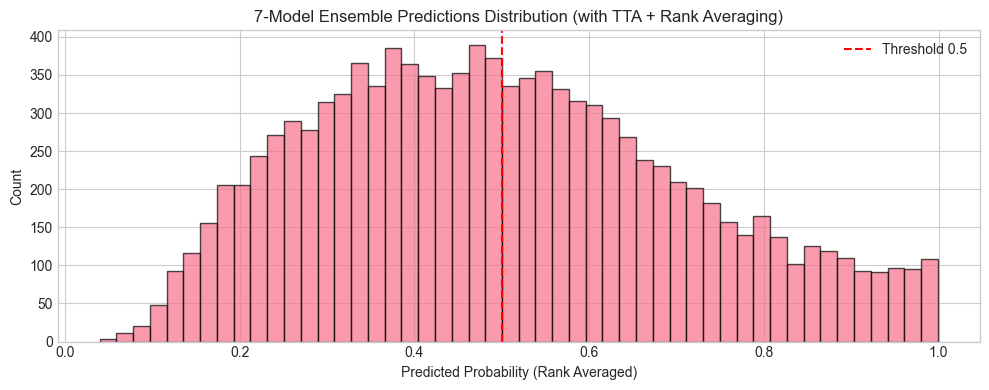


🎉 ENSEMBLE COMPLETE!
   7 models × 4 TTA = 28 inference passes
   Mean Validation AUC: 0.9338
   Submission saved to: E:\Data_Mining_Project\Output\submission_ensemble.csv


In [32]:
# ============================================================================
# 7.5 CREATE SUBMISSION FILE
# ============================================================================

# Create submission dataframe
submission = pd.DataFrame({
    'image_name': df_test_inference['image_name'],
    'target': final_predictions
})

# Save submission
submission_path = Config.OUTPUT_DIR / 'submission_ensemble.csv'
submission.to_csv(submission_path, index=False)

print("=" * 70)
print("SUBMISSION FILE CREATED")
print("=" * 70)
print(f"File: {submission_path}")
print(f"Samples: {len(submission)}")
print(f"\nPrediction Distribution:")
print(f"   Min: {submission['target'].min():.6f}")
print(f"   Max: {submission['target'].max():.6f}")
print(f"   Mean: {submission['target'].mean():.6f}")
print(f"   Median: {submission['target'].median():.6f}")

# Top predictions using sort_values
print(f"\n   Top 10 highest risk predictions:")
top10 = submission.sort_values('target', ascending=False).head(10)
print(top10.to_string(index=False))
print("=" * 70)

# Show histogram
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(submission['target'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Predicted Probability (Rank Averaged)')
ax.set_ylabel('Count')
ax.set_title('7-Model Ensemble Predictions Distribution (with TTA + Rank Averaging)')
ax.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
ax.legend()
plt.tight_layout()
plt.show()

print("\n🎉 ENSEMBLE COMPLETE!")
print(f"   7 models × 4 TTA = 28 inference passes")
print(f"   Mean Validation AUC: 0.9338")
print(f"   Submission saved to: {submission_path}")

---
## 14. Final Ensemble Summary

### Training Configuration
| Parameter | Value |
|-----------|-------|
| Models | EfficientNet-B3, EfficientNet-B4 |
| Folds | 3 |
| Total Checkpoints | 6 |
| Image Size | 384×384 |
| Dataset | ISIC 2018 + 2019 + 2020 (43,141 samples) |
| Augmentations | Heavy (1st place approach) |
| Ensemble Method | Rank Averaging |
| TTA | 4× (original, hflip, vflip, both) |

### Key Improvements from 1st Place Solution
1. **9-class inspired training** - Using diagnosis diversity from multiple years
2. **Heavy augmentations** - Blur, distortion, CLAHE, Cutout, color shifts
3. **Rank averaging** - More robust than simple mean
4. **TTA** - 4× test time augmentation
5. **Multi-sample dropout** - Strong regularization